<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

#### <span style="color:darkred">__Part 1: Data Exploration__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-exploration.ipynb </span><br><br><span style="color:darkred">__Part 2: Models__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-models.ipynb </span>

----

# <span style="color:darkred">Part 1: </span><span style="color:darkblue">L1 Prediction from ELL Writing Samples</span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> http://lang-8.com/ [scraped with Beautiful Soup]

![alt text](../data/language/lang8.png "Title")

__Summary:__
> In my previous profession, I have been teaching English to a diverse range of students of all ages, language background, and country origin. During my professional development, I started to observe that different students with different L1s (1st Language) tended to display different patterns of communication that appeared to have some connection to either education in their country of origin or a connection to the linguistic structure of their first language. Different ELL (English Language Learners) needed to focus on different aspects of the English language depending on their background. The purpose of this project is to use a large number of blog posts from a language practicing website and explore whether or not the L1 has any significant impact on the blog writing style of the English learner.<br><br>Part 1: Explore the data to find any noteworthy trends in linguistic structure: <ol><li> vocabulary (word freq, collocations, and cognates) <li>syntax (sentence structure)<li>grammar (i.e. grammar complexity of sentences) <li>errors (types of errors) <li> parts of speech (NLTK Abbreviations: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/)</ol><br>Part 2: Use linguistic trends to determine whether or not a learner's first language can be predicted.

__Variables:__
>__id:__ _User ID_<br>
__time:__ _Time the blog post was scraped (in order of user posted time)_ <br>
__title:__ _Title of the blog post_<br>
__content:__ _The blog post_<br>
__language:__ _User's self-reported first language_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> L1 (first language) experience and academic environment influences ELLs' (English Language Learners') writing style. The L1 of ELLs can be predicted by looking at English blog posts and identifying patterns unique to their L1.

__Observations:__
><li> --<li>--<li>--

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

http://www.anc.org/data/anc-second-release/frequency-data/

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# from nltk.corpus import brown
# nltk.download('brown')

In [2]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import scipy
import pandas as pd
import plotly as plo
import numpy as np
import seaborn as sns
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, median_test, f_oneway,mood, shapiro

# NLP
import textblob
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib
from string import punctuation

# import altair as alt

In [3]:
# load and close files
def get_text(link):
    with open(link) as f:
        output = f.read()
    return output

In [4]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [5]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')
blog.info()

# POS Table for reference
poscv = pd.read_csv('../data/pos.csv')
poscv = poscv.iloc[0:17]
poscv.columns = ['Set1','Set 2']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17141 entries, 0 to 17140
Data columns (total 6 columns):
Unnamed: 0    17141 non-null int64
id            17141 non-null int64
time          17141 non-null object
title         17141 non-null object
content       17141 non-null object
language      17141 non-null object
dtypes: int64(2), object(4)
memory usage: 803.6+ KB


In [6]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')

# Clean Data
del blog['Unnamed: 0']
blog.language = blog.language.mask(blog.language == 'Mandarin', 'Traditional Chinese').replace(['Persian', 'Arabic',
        'Bulgarian', 'Swedish', 'Slovenian', 'Slovak', 'Malay', 'Turkish','Romanian', 'Czech', 'Danish', 'Vietnamese',
        'Norwegian','Serbian','Other language','Lithuanian', 'Ukrainian', 'Finnish','Estonian','Bengali','Russian', 
        'Spanish','French', 'German', 'Cantonese','Mongolian', 'Tagalog', 'Polish', 'Dutch','Italian', 'Portuguese(Brazil)', 
        'Thai', 'Indonesian', 'Cantonese','Urdu', 'Hungarian','Korean','English'], np.nan)
blog = blog.dropna().sample(frac=1)

del blog['title']
del blog['time']

In [7]:
blog.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14262 entries, 6475 to 4031
Columns: 3 entries, id to language
dtypes: int64(1), object(2)

In [8]:
blog.head()

,id,content,language
6475,1817,"As you know, today is begining of the new year...",Japanese
9221,2616,I fixed the filter on my window. Because the v...,Japanese
15628,4597,Grandmothers (grand mother and grand mother in...,Japanese
8405,2347,"I was busy this week.So,I didnt write my journ...",Japanese
4806,1167,I got a photo card from my friend today. It in...,Japanese


In [9]:
# Confirmation that there are no more null values
blog.isnull().values.any()

False

In [10]:
def lettercheck(val):
    reLetters = re.compile('[^a-zA-Z]')
    onlyletters = reLetters.sub('', val)
    return len(onlyletters)/len(val)

In [11]:
blog['letters_per'] = blog.content.apply(lettercheck)
print('Removing Blogs with less than 70% letter percentage: {}'.format(blog.loc[blog['letters_per'] <= .7].content.count()))
blog = blog.loc[blog['letters_per'] > .7]

Removing Blogs with less than 70% letter percentage: 1227


In [12]:
blog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13035 entries, 6475 to 4031
Data columns (total 4 columns):
id             13035 non-null int64
content        13035 non-null object
language       13035 non-null object
letters_per    13035 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 509.2+ KB


<a id="sec2"></a>

# <span style="color:darkblue">2. Exploring the Data</span>  <a href='#top'>(top)</a>

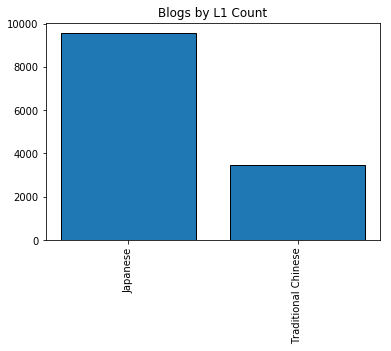

In [13]:
vals = list(blog.language.value_counts().values)
languages = list(blog.language.value_counts().index)
plt.figure(figsize(6,4))
plt.bar(languages,vals,edgecolor='black')
plt.title('Blogs by L1 Count')
plt.xticks(rotation='vertical')
plt.show()

In [14]:
print("Posts by 'Native' English Speakers: {}".format(blog.id.loc[blog.language == 'English'].count()))

Posts by 'Native' English Speakers: 0


<a id="nlp"></a>

### <span style="color:darkred">NLP: Spell Check, Tokenization, Collocations, Parts of Speech, and Syntax</span>  <a href='#top'>(top)</a>

__Word Level Ranking__

In [15]:
ANCI_WORDS = pd.read_csv('../data/language/ANC-written-count.txt', 
                         sep='\t', 
                         encoding='latin-1', 
                         names=['word','stem','pos','freq'],header=None)
word_freq = list(zip(ANCI_WORDS['word'].values,ANCI_WORDS['freq'].values))

full_words_dict = {}
words_dict = {}

# full_freq
i = 0
for w in word_freq:
    i = i + 1
    if w[0] not in full_words_dict:
        full_words_dict[w[0]] = w[1]
        
# basic_freq
i = 0
for w in word_freq:
    i = i + 1
    if w[0] not in words_dict:
        if i < 500:
            words_dict[w[0]] = 1
        elif (i >= 500) & (i < 5000):
            words_dict[w[0]] = 2
        elif (i >= 5000) & (i < 10000):
            words_dict[w[0]] = 3
        elif (i >= 5000) & (i < 20000):
            words_dict[w[0]] = 4

In [16]:
def full_freq_rating(l):
    score = 0
    c=0
    for w in l:
        if w in full_words_dict:
            c = c + 1
            score = score + full_words_dict[w]
    if c == 0:
        c=1
    return score / c

def freq_rating(l):
    score = 0
    c=0
    for w in l:
        if w in words_dict:
            c = c + 1
            score = score + words_dict[w]
    if c == 0:
        c=1
    return score / c

__TextBlob__

In [17]:
%%time
blob = blog.content.apply(lambda val: textblob.TextBlob(val))

CPU times: user 182 ms, sys: 5.23 ms, total: 187 ms
Wall time: 193 ms


In [18]:
def posbigram(val):
    bigramlist,l = [],[]
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        bigrm = list(nltk.bigrams(l))
        
        for bigram in bigrm:
            bigramlist.append('-'.join(bigram))
        
    return bigramlist

def postrigram(val):
    trigramlist, l = [],[]
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        trigrm = list(nltk.trigrams(l))
        
        for trigram in trigrm:
            trigramlist.append('-'.join(trigram))
        
    return trigramlist

In [19]:
def per_check(string_value, total):
    percentage = len(string_value)
    if percentage != 0:
        percentage = float(total / percentage) * 100
    else:
        percentage = 0
    return percentage

def punc_count(string_value):
    count = 0
    for c in string_value:
        if c in punctuation:
            count+= 1
    return per_check(string_value, count)

def caplet_count(string_value):
    count = 0
    for c in string_value:
        if c.isupper():
            count+= 1
    return per_check(string_value, count)      

__General Text Analysis__

In [20]:
%%time
blog['wc'] = blob.apply(lambda val: len(val.words))
blog['sc'] = blob.apply(lambda val: len(val.sentences))
blog['tokens'] = blob.apply(lambda val: [w.lower() for w in val.words])
blog['sent_pol'] = blob.apply(lambda val: val.sentiment[0])
blog['sent_subj'] = blob.apply(lambda val: val.sentiment[1])
blog['cap_let'] = blob.apply(caplet_count)
blog['punc_count'] = blob.apply(punc_count)

CPU times: user 43.9 s, sys: 919 ms, total: 44.8 s
Wall time: 45.8 s


In [21]:
blog['freq_score'] = blob.apply(lambda val: freq_rating(val.words))
blog['full_freq_score'] = blob.apply(lambda val: full_freq_rating(val.words))

__Data Cleaning Round 2__

In [22]:
blog = blog[blog['wc'] >= 4]
blog = blog[blog['full_freq_score'] > 1500]

__Parts of Speech Tokens__

In [23]:
%%time
blog['pos'] = blob.apply(lambda val: [v[1] for v in val.tags])
blog['pos2'] = blob.apply(posbigram)
blog['pos3'] = blob.apply(postrigram)

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/util.py:491: DeprecationWarning:

generator 'ngrams' raised StopIteration



CPU times: user 4min 56s, sys: 7.22 s, total: 5min 3s
Wall time: 5min 8s


__Backup File__

__Frequent Words Per Language__

In [24]:
%%time
js = Counter(reduce((lambda x, y: x + y), blog.content[blog.language == 'Japanese'].str.lower().apply(nltk.word_tokenize))).most_common(1000)
cs = Counter(reduce((lambda x, y: x + y), blog.content[blog.language == 'Traditional Chinese'].str.lower().apply(nltk.word_tokenize))).most_common(1000)
cl,jl = [l[0] for l in cs],[l[0] for l in js]
cuw,juw = [item for item in cl if item not in jl],[item for item in jl if item not in cl]

CPU times: user 1min 3s, sys: 16.7 s, total: 1min 19s
Wall time: 1min 21s


<a id="feature"></a>

# <span style="color:darkblue">2. Feature Processing:</span>  <a href='#top'>(top)</a>

In [25]:
def create_dummy_binary_df(df,col,name,keep=[],):
    colset = set(df[col].sum())
    finalsetlist = []
    if len(keep) > 0:
        colset = [k for k in keep if k in colset]
    
    for c in colset:
        colname = name+'_'+str(c)
        df[colname] = df[col].apply(lambda val: val.count(c))
        
        if df[colname].sum() < 1:
            del df[colname]
        else:
            finalsetlist.append(colname)
        
    print('Created dummy counter for {} features'.format(name))
        
    return finalsetlist

In [26]:
def create_dummy_count_df(df,col,colset,name,keep=[]): 
    finalsetlist = []
    if len(keep) > 0:
        colset = [k for k in keep if k in colset]
    
    for c in colset:
        colname = name+'_'+str(c)
        df[colname] = df[col].apply(lambda val: val.count(c))
        
        if df[colname].sum() < 1:
            del df[colname]
        else:
            finalsetlist.append(colname)
        
    print('Created dummy counter for {} features'.format(name))
        
    return finalsetlist

In [27]:
%%time
colset = set(blog['tokens'].sum())

CPU times: user 1min 34s, sys: 25.8 s, total: 2min
Wall time: 2min 6s


In [28]:
%%time
prplist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'PRP'])
pronouns = create_dummy_count_df(blog,'tokens',colset,'prp',prplist)

cclist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'CC'])
coordinators = create_dummy_count_df(blog,'tokens',colset,'cc',cclist)

inlist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'IN'])
preposition = create_dummy_count_df(blog,'tokens',colset,'prep',inlist)

adverblist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'RB'])[0:50]
adverb = create_dummy_count_df(blog,'tokens',colset,'adv',adverblist)

punct = create_dummy_count_df(blog,'tokens',colset,'punct',list(punctuation))

cuw = create_dummy_count_df(blog,'tokens',colset,'cuw',cuw)
juw = create_dummy_count_df(blog,'tokens',colset,'juw',cuw)

Created dummy counter for prp features
Created dummy counter for cc features
Created dummy counter for prep features
Created dummy counter for adv features
Created dummy counter for punct features
Created dummy counter for cuw features
Created dummy counter for juw features
CPU times: user 9.87 s, sys: 603 ms, total: 10.5 s
Wall time: 12.2 s


In [29]:
%%time
pos1set = set(blog['pos'].sum())
pos2set = set(blog['pos2'].sum())
pos3set = set(blog['pos3'].sum())

CPU times: user 3min 52s, sys: 1min 5s, total: 4min 57s
Wall time: 5min 5s


In [30]:
%%time
pos2 = create_dummy_count_df(blog,'pos2',pos1set,'pos2')
pos1 = create_dummy_count_df(blog,'pos',pos2set,'pos1')

Created dummy counter for pos2 features
Created dummy counter for pos1 features
CPU times: user 22.8 s, sys: 491 ms, total: 23.3 s
Wall time: 23.7 s


In [31]:
%%time
pos3 = create_dummy_count_df(blog,'pos3',pos3set,'pos3')

Created dummy counter for pos3 features
CPU times: user 7min 22s, sys: 1min 23s, total: 8min 45s
Wall time: 8min 57s


In [32]:
letters1 = []
for let in 'abcdefghijklmnopqrstuvwxyz':
    name = 'let1_'+let
    blog[name] = blog.tokens.apply(lambda val: ''.join(val).count(let))
    letters1.append(name)

In [33]:
%%time
alphabet = list('abcdefghijklmnopqrstuvwxyz')
letters2 = []
for let in alphabet:
    for let2 in alphabet:
        letters2.append(let+let2)

letters2name = []        
for let in letters2:
    name = 'let2_'+let
    blog[name] = blog.tokens.apply(lambda val: ' '.join(val).count(let))
    if blog[name].sum() < 10:
        del blog[name]
    else:
        letters2name.append(name)        
letters2 = letters2name

CPU times: user 41.1 s, sys: 7.23 s, total: 48.3 s
Wall time: 49.3 s


In [34]:
%%time
blog.to_csv('blogfeatures.csv')

CPU times: user 2min 54s, sys: 12.7 s, total: 3min 6s
Wall time: 3min 10s


<a id="sec3"></a>

In [ ]:
chinesecognates = '''Amen
ammonia
amoeba
amoxicillin
ampere
amphetamine
ampoule
angel
antitrust
Apollo
Arcadia
aspartame
Aspirin
avatar
baby
Baccarat
bacon
bagel
ballet
bandage
banjo
bar
Baroque
bass
bassoon
bazooka
beer
beta
bikini
bingo
bit (unit of information)
blog
blues
bolero
bourgeois
bow tie
brandy
brownie
buffet
bullying
bungee jumping
bus
butter
bye-bye
caffeine
calorie
camera
cancan
cannon
carat
carbine
carnival
cartel
cartoon
cashmere
cellophane
celluloid
cement
cha-cha
Champagne
cheese
cherry
chiffon
chocolate
cholera
cider
cigar
clone
coca
cocaine
cocktail
cocoa
codeine
coffee
combine harvester
condom
cookie
cool
copy
couch
coup
coupon
craton
cream
crêpe
croissant
cubic centimeter
cumin
curry
cyanide
Dacron
daddy
didgeridoo
disco
dogfish
domino
doughnut
drive-thru
dynamite
email
motor
Eucalyptus
fantasy
fascism
fillet
film
fuck
geek
ghetto
go-kart
golf
google
guitar
Gypsy
hacker
hallelujah
hamburger
hate
hello
heroin
hippie
honey
hot dog
index
information technology
insurance
jacket
jazz
Jeep
jitterbug
Kentucky Fried Chicken
ketamine
khaki
koala
lace
lacquer
laser
latte
lemon
lesbian
limbo
lime
liquor
logic
lottery
mankini
marathon
margarine
marker
Martini
massage
McDonald's
meme
Mensa
microphone
milkshake
Mister
model
modern
mohair
mommy
montage
mosaic
motif
motor
mousse
mozzarella
muffin
mug
mummy
nazi
negro
neon
nicotine
Nylon
ohm
Olympics
Opec
opium
parfait
parka
party
penicillin
Pharaoh
pickup truck
pizza
poker
polka
pudding
pump
punk
rabbi
radar
roller
romance
rum
rumba
salad
salmon
salon
sandwich
sardine
sauna
saxophone
science
scooter
shampoo
sherry
shirt
shit
sirloin
snooker
soda
Starbucks
strawberry
sundae
ping-pong
talk show
tango
tank
tannic acid
tarot
Teflon
ten-pin bowling (or the ball)
TNT
tobacco
toefl
toffee
toolbar
tuna
turquoise
valve
Vaseline
violin
vitamin
vodka
waltz
watt
whisky
yoga
yogurt
yo-yo
café'''

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

_There is a lower English sample count so higher variance is expected._

__Reject Outliers__

In [37]:
from statsmodels import robust

def MEDIAN_reject_outliers(data, m=3):
    data = data[abs(data - np.median(data)) < m*robust.mad(data)]
    return data[~np.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~np.isnan(data)].sort_values()

# lanlenseries = [reject_outliers(blog.char_count[blog.language == l]) for l in list(blog.language.unique())]

__Create Analysis Set__

In [38]:
import_features = ['pos3_JJ-FW-FW', 'sc', 'pos3_DT-JJS-VBZ', 'sent_subj', 'punc_count', 'pos3_NN-POS-WRB', 'wc', 'pos3_JJR-JJ-VBZ', 'prep_like', 'pos3_PRP$-VBG-CC', 'pos3_JJ-PRP-DT', 'pos3_NNS-WRB-JJ', 'pos3_PDT-DT-NN', 'pos3_VBD-CD-WRB', 'pos3_PRP-FW-PRP', 'pos3_NNP-VBD-JJ', 'pos3_RB-PRP$-MD', 'pos3_VBZ-JJR-JJ', 'pos3_JJ-TO-PRP', 'letters_per', 'prep_across', 'prp_he', 'pos3_JJ-CD-JJ', 'pos3_VB-VBG-NNS', 'pos3_VBZ-VBG-JJR', 'pos3_VBZ-PRP$-IN', 'sent_pol', 'pos3_RB-VBG-VB', 'pos3_NN-VBD-MD', 'full_freq_score', 'cap_let', 'freq_score', 'pos3_VB-RB-MD', 'pos3_PRP-VBP-VBD', 'pos3_NNP-NNS-NNP', 'pos3_NN-UH-VB', 'pos3_PRP$-NN-POS', 'pos3_PRP-IN-JJS', 'pos3_PRP$-RP-IN', 'prep_while', 'pos3_TO-CC-WRB', 'pos3_NN-CC-VBD', 'pos3_VBD-CD-JJ', 'pos3_RB-PRP$-CD', 'pos3_VB-PRP-WRB', 'pos3_PRP-RBR-PRP', 'pos3_VB-NNP-MD', 'pos3_VB-JJ-SYM', 'pos3_VBZ-VB-DT', 'pos3_NNP-NN-RP', 'pos3_CD-NN-RB', 'pos3_RP-NN-RB', 'pos3_VBG-NNS-RP', 'pos3_WDT-PRP-VBD', 'pos3_RP-RB-TO', 'pos3_WRB-PRP-NNS', 'pos3_JJS-JJ-VBP', 'pos3_VBZ-JJR-DT', 'pos3_RB-NNS-VBD', 'pos3_CD-JJR-CD', 'pos3_NNPS-VBN-IN', 'pos3_VBZ-CC-VBG', 'pos3_WRB-CC-VB', 'pos3_NNS-RB-RB', 'pos3_JJ-POS-MD', 'pos3_RBR-CC-VB', 'pos3_CC-JJ-VBD', 'pos3_MD-IN-DT', 'prep_between', 'pos3_CC-CC-PRP', 'pos3_VBP-NN-VBN', 'pos3_PRP-CD-JJ', 'pos3_RP-NNS-WP', 'pos3_RB-MD-RBR', 'pos3_JJ-WRB-PRP$', 'pos3_PRP-WP-PRP', 'pos3_JJ-RB-VBZ', 'pos3_NNS-DT-VBP', 'pos3_VB-VB-CC', 'pos3_VBN-VBD-TO', 'pos3_RP-RP-NN', 'pos3_RB-WP-NN', 'pos3_VBN-EX-VBZ', 'pos3_VB-TO-RBR', 'pos3_JJS-DT-VBZ', 'pos3_RB-IN-PRP$', 'pos3_CC-WDT-MD', 'pos3_RB-JJ-PDT', 'pos3_VBN-PRP-RP', 'pos3_VBZ-NNP-DT', 'pos3_CC-VBN-RB', 'pos3_VBP-NNS-NNS', 'pos3_VBN-PRP$-JJS', 'pos3_JJ-CD-CC', 'pos3_CC-VB-JJR', 'pos3_VBP-POS-DT', 'pos3_SYM-CD-NNP', 'cc_et', 'pos3_RP-RB-PRP', 'pos3_JJ-TO-PRP$']
full_features = import_features + ['language']
analysis = features[full_features]

__Plot Hist__

_Decision Tree Truncated SVD Features_

/Users/ryan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning:

invalid value encountered in true_divide

/Users/ryan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars

/Users/ryan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning:

invalid value encountered in reduce



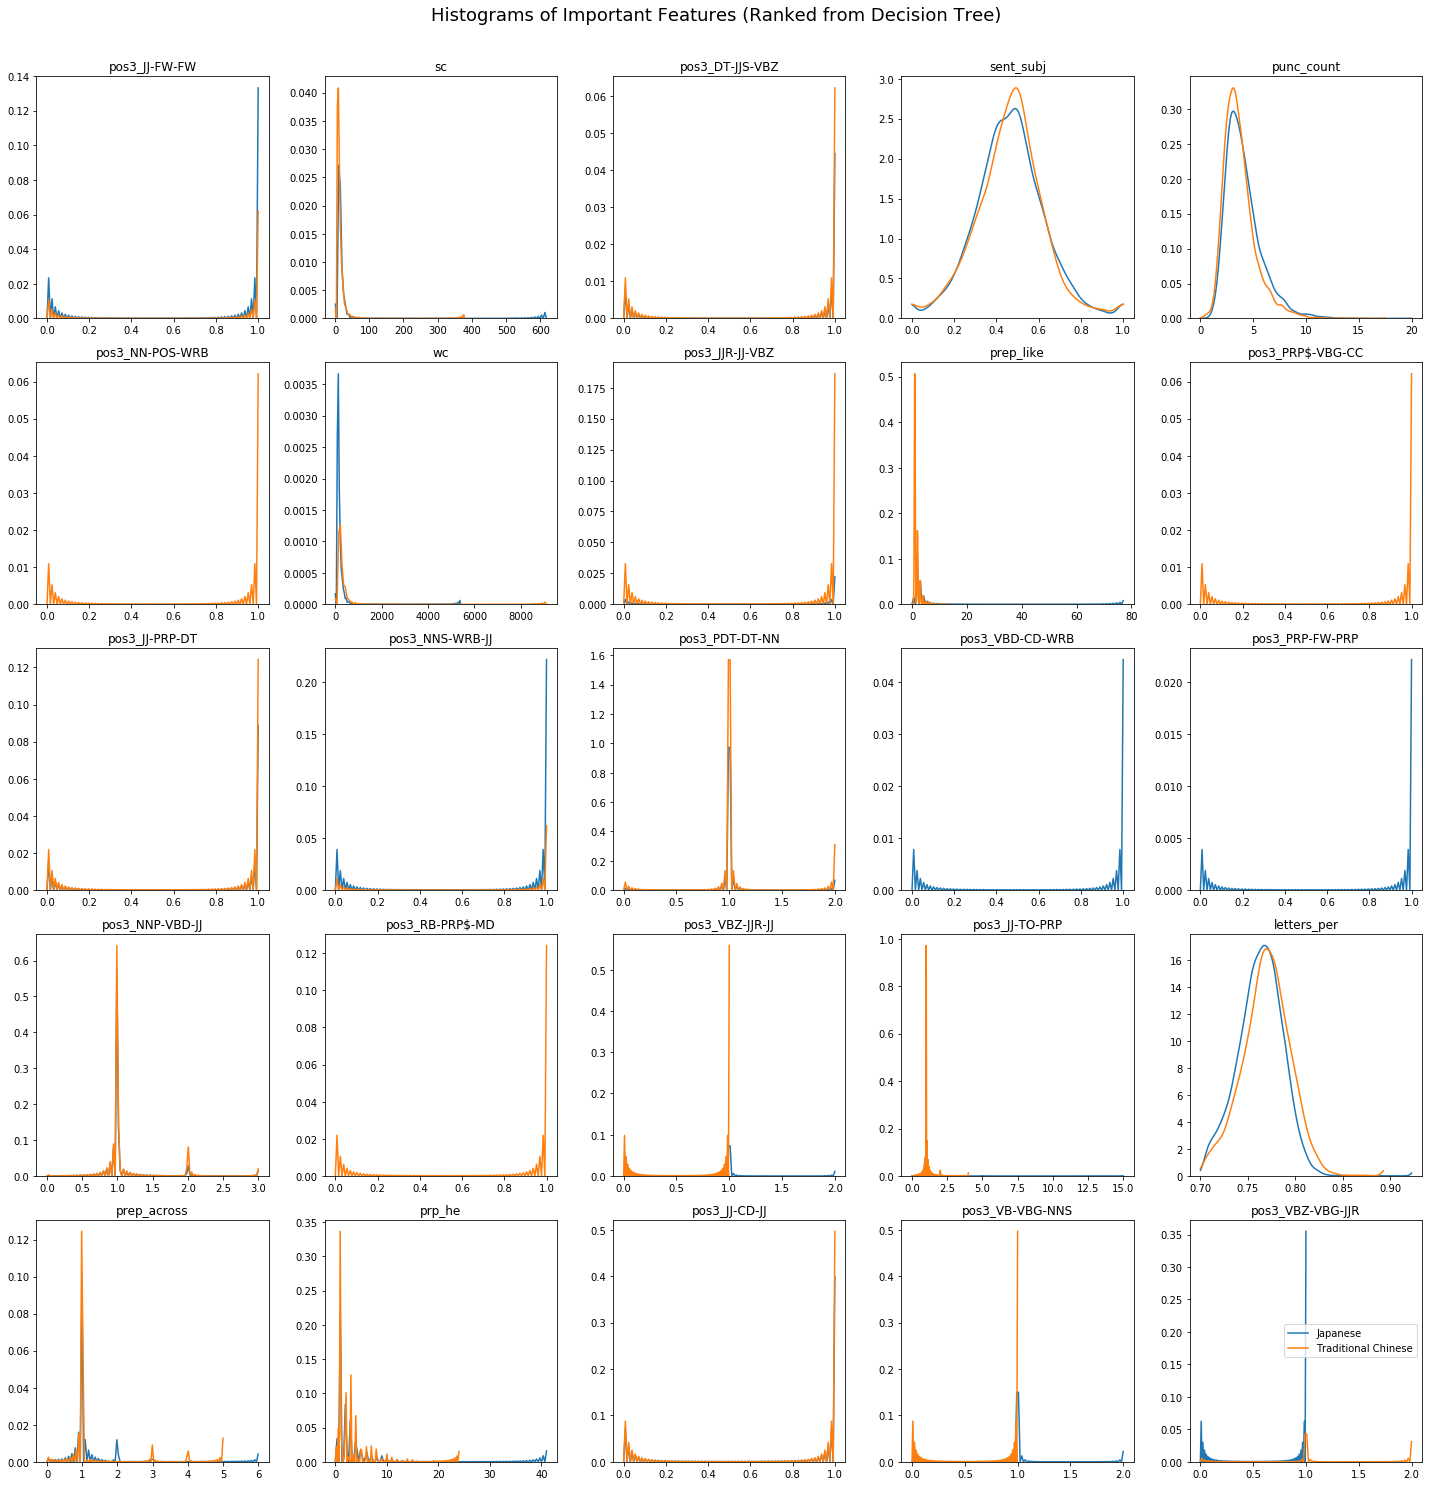

In [39]:
i = 1
fig=plt.figure(figsize=(20,20))
for feat in import_features[0:25]:
    plt.subplot(5, 5, i)
    i = i + 1
    langfeats = [(analysis[feat][analysis.language == l]) for l in lang]
    for g in langfeats:
        sns.kdeplot(g,legend=None,kernel='gau',shade=False,cut=0)
        plt.title(feat)

fig.suptitle('Histograms of Important Features (Ranked from Decision Tree)', fontsize=18, y=1.03)
plt.tight_layout()
plt.legend(lang)
plt.show()

In [40]:
for c in import_features:
    p = shapiro(blog[c])[1]
    if (p < .05) & (p > 0):
        print('{}:\x1b[92m{}\x1b[0m'.format(c,p),end='|')
    elif p > .05:
        print('{}:\x1b[31m{}\x1b[0m'.format(c,p),end='|')
    else:
        print('{}:\x1b[33m{}\x1b[0m'.format(c,p),end='|')

/Users/ryan/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning:

p-value may not be accurate for N > 5000.



pos3_JJ-FW-FW:0.0|sc:0.0|pos3_DT-JJS-VBZ:0.0|sent_subj:3.2764552529309356e-38|punc_count:0.0|pos3_NN-POS-WRB:0.0|wc:0.0|pos3_JJR-JJ-VBZ:0.0|prep_like:0.0|pos3_PRP$-VBG-CC:0.0|pos3_JJ-PRP-DT:0.0|pos3_NNS-WRB-JJ:0.0|pos3_PDT-DT-NN:0.0|pos3_VBD-CD-WRB:0.0|pos3_PRP-FW-PRP:0.0|pos3_NNP-VBD-JJ:0.0|pos3_RB-PRP$-MD:0.0|pos3_VBZ-JJR-JJ:0.0|pos3_JJ-TO-PRP:0.0|letters_per:3.851288704175285e-25|prep_across:0.0|prp_he:0.0|pos3_JJ-CD-JJ:0.0|pos3_VB-VBG-NNS:0.0|pos3_VBZ-VBG-JJR:0.0|pos3_VBZ-PRP$-IN:0.0|sent_pol:0.0|pos3_RB-VBG-VB:0.0|pos3_NN-VBD-MD:0.0|full_freq_score:1.401298464324817e-45|cap_let:0.0|freq_score:0.0|pos3_VB-RB-MD:0.0|pos3_PRP-VBP-VBD:0.0|pos3_NNP-NNS-NNP:0.0|pos3_NN-UH-VB:0.0|pos3_PRP$-NN-POS:0.0|pos3_PRP-IN-JJS:0.0|pos3_PRP$-RP-IN:0.0|prep_while:0.0|pos3_TO-CC-WRB:0.0|pos3_NN-CC-VBD:0.0|pos3_VBD-CD-JJ:0.0|pos3_RB-PRP$-CD:0.0|pos3_VB-PRP-WRB:0.0|pos3_PRP-RBR-PRP:0.0|pos3_VB-NNP-MD:0.0|pos3_VB-JJ-SYM:0.0|pos3_VBZ-VB-DT:0.0|pos3_NNP-NN-RP:0.0|pos3_CD-NN-RB:0.0|pos3_RP-NN-RB:0.0|pos3_VB

In [41]:
exclude = ['id','content','language','tokens','pos','pos2','pos3','nns']

In [42]:
goodlist = []
for c in list(blog.columns):
    if c not in exclude:

        p = shapiro(blog[c])[1]
        if (p < .05) & (p > 0):
            print('{}:\x1b[92m{}\x1b[0m'.format(c,p),end='|')
            goodlist.append(c)   
        elif p > .05:
            print('{}:\x1b[31m{}\x1b[0m'.format(c,p),end='|')
        else:
            pass
#             print('{}:\x1b[33m{}\x1b[0m'.format(c,p),end='|')


letters_per:3.851288704175285e-25|sent_subj:3.2764552529309356e-38|full_freq_score:1.401298464324817e-45|

/Users/ryan/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning:

p-value may not be accurate for N > 5000.



In [43]:
goodlist

['letters_per', 'sent_subj', 'full_freq_score']

__Correlations (of top features by decision tree importance)__

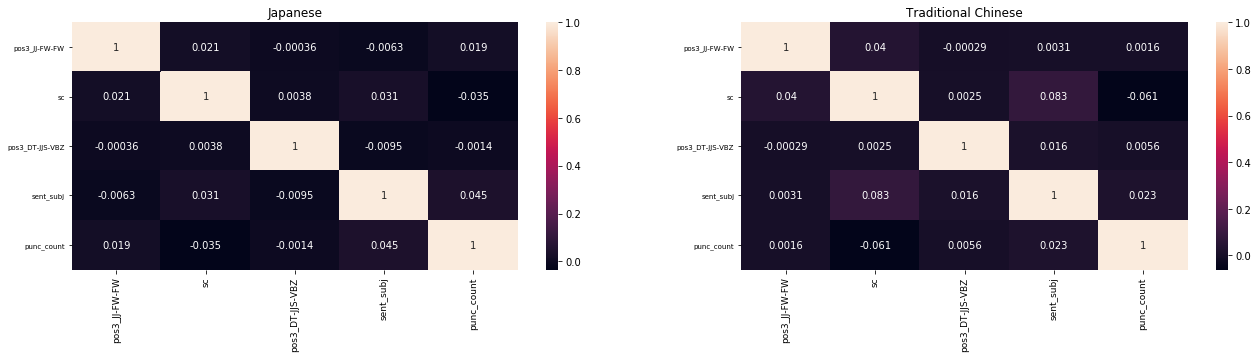

In [44]:
# corr = analysis.corr(); print(corr)
i = 1
fig=plt.figure(figsize=(22,10))

for ind,g in enumerate([(analysis[import_features[0:5]][analysis.language == l]) for l in lang]):
    plt.subplot(2, 2, i)
    i = i + 1
    
    corr = g.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)
    plt.title(lang[ind])
    plt.xticks(rotation='vertical',fontsize = 9)
    plt.yticks(rotation='horizontal',fontsize = 7)
    
plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

In [45]:
from scipy.stats import median_test
def mw_test(a,b):
    stat,p = mannwhitneyu(a,b, use_continuity=True, alternative=None)
    return stat,p

def moods_median_test(a,b,c,d):
    stat, p, med, tbl = median_test(a,b,c,d)
    return stat,p

def f1way_test(a,b,c,d):
    f,b = f_oneway(a,b,c,d)
    return f,b

import warnings
warnings.filterwarnings('ignore')

__Mann Whitney U test (2 Non-Normally Distributed Independent Samples)__

In [46]:
print('[Japanese -- Chinese]')

for c in blog.columns:
    
    if c not in exclude:
        
        g = [(blog[c][blog.language == l]) for l in lang]
        stat,p = mw_test(g[0],g[1])
        vals = 'stat={}, p={}'.format(stat,p)
        if p < .05:
            print('{}:\x1b[92m{}\x1b[0m'.format(c,vals))
        else:
            print('{}:\x1b[31m{}\x1b[0m'.format(c,vals))
poscv

[Japanese -- Chinese]
letters_per:stat=13856605.0, p=1.442175371008038e-37
wc:stat=15252050.0, p=5.728509478378378e-08
sc:stat=12702901.0, p=1.778377085868085e-80
sent_pol:stat=15934911.5, p=0.04903985854196146
sent_subj:stat=16185173.0, p=0.37549953071391845
cap_let:stat=12242892.5, p=1.1123226049693227e-101
punc_count:stat=13947768.5, p=6.638073711310552e-35
freq_score:stat=12983742.0, p=2.9652099497082266e-68
full_freq_score:stat=15010731.0, p=2.1851956788731783e-11
prp_i:stat=15284384.5, p=1.3145378530533502e-07
prp_it:stat=15746992.0, p=0.0030786145123389785
prp_he:stat=16217713.5, p=0.40522316875155895
prp_you:stat=15782493.0, p=0.0020368085517747797
prp_they:stat=16239045.5, p=0.4828108312007478
prp_we:stat=15455075.5, p=1.5249202152019956e-08
prp_she:stat=16161838.5, p=0.19274064970869093
prp_me:stat=13899496.5, p=6.941603932770458e-48
prp_them:stat=16189266.0, p=0.31910597767177956
prp_him:stat=16185293.0, p=0.2353619898791779
prp_us:stat=15342867.0, p=8.571527171013814e-25
pr

cuw_benefits:stat=16146549.0, p=1.402162430861182e-07
cuw_beijing:stat=15886569.0, p=1.3769711452817408e-40
cuw_taiwan:stat=15926640.5, p=1.1117494963153312e-24
cuw_choice:stat=15989360.5, p=3.8110291168818976e-13
cuw_employees:stat=16227208.0, p=0.2189454757107489
cuw_science:stat=15999185.5, p=8.434458342331527e-16
cuw_learners:stat=16239963.0, p=0.4142078294371095
cuw_technology:stat=16071377.5, p=6.274508283025295e-09
cuw_happiness:stat=16031481.0, p=1.2167920796981842e-10
cuw_relationship:stat=16100732.0, p=6.7866573644495234e-06
cuw_process:stat=15954284.0, p=9.740939832179943e-21
cuw_period:stat=16092899.0, p=1.0226439913403946e-05
cuw_attention:stat=15986103.0, p=3.3651890358288265e-15
cuw_benefit:stat=16166962.5, p=4.842260798317256e-06
cuw_dear:stat=15992156.0, p=2.483982358475291e-13
cuw_classmates:stat=15940689.0, p=3.085230242098009e-23
cuw_economic:stat=16105578.5, p=3.34010978003348e-07
cuw_product:stat=16108886.0, p=7.804593008843882e-07
cuw_boring:stat=15981051.5, p=2.

cuw_figure:stat=16155377.5, p=0.0005291327857636589
cuw_include:stat=16146868.0, p=1.5342732175348484e-05
cuw_touch:stat=16185378.0, p=0.028906796656711704
cuw_progress:stat=16121312.5, p=2.6854864490400785e-06
cuw_behind:stat=16152622.5, p=0.0005349007836751911
cuw_six:stat=16215775.0, p=0.1687784600709059
cuw_oral:stat=16090341.5, p=8.738548161420714e-15
cuw_animal:stat=16229967.5, p=0.24999016542810626
cuw_mood:stat=16125737.5, p=3.222322410866137e-06
cuw_classmate:stat=16097068.5, p=8.460020248538132e-13
cuw_exactly:stat=16158387.5, p=0.0018140982876299026
cuw_cellphone:stat=16177149.5, p=0.00017672956809119416
cuw_door:stat=16146995.0, p=0.00011522001847913132
cuw_activity:stat=16177707.0, p=0.010752740162909804
cuw_rich:stat=16149687.5, p=0.0004155196113058258
cuw_studies:stat=16169274.5, p=0.0005561093711493728
cuw_deep:stat=16138318.5, p=9.793895874703715e-05
cuw_nature:stat=16220943.0, p=0.2071442667494785
cuw_state:stat=16179150.0, p=0.006766600928498701
cuw_achieve:stat=1611

pos3_RBR-VB-JJ:stat=16242872.5, p=0.27506956431062657
pos3_RP-VBP-RB:stat=16239808.0, p=0.04718049699596737
pos3_DT-VBP-RB:stat=16192842.5, p=0.007986508947862661
pos3_WRB-CD-VBD:stat=16241169.0, p=0.19899334761774667
pos3_RB-CC-JJ:stat=16240448.5, p=0.4296108359033143
pos3_RB-JJ-NNS:stat=15876886.0, p=2.72256204497084e-06
pos3_TO-VBG-CC:stat=16240493.0, p=0.31645349171447856
pos3_DT-NNPS-RB:stat=16240826.0, p=0.2955619852646494
pos3_VBP-TO-VBD:stat=16241854.0, p=0.348297215447796
pos3_WDT-CC-WRB:stat=16241169.0, p=0.19899334761774667
pos3_JJR-VB-PRP:stat=16242872.5, p=0.27506956431062657
pos3_CC-JJR-NNP:stat=16242530.0, p=0.37409472593377546
pos3_POS-JJ-FW:stat=16242872.5, p=0.27506956431062657
pos3_JJ-TO-WRB:stat=16241169.0, p=0.19899334761774667
pos3_CC-PRP$-PRP$:stat=16235040.0, p=0.008991870731703346
pos3_RBR-NN-WRB:stat=16239808.0, p=0.04718049699596737
pos3_WDT-NNS-NNS:stat=16241169.0, p=0.19899334761774667
pos3_VBP-VBD-CC:stat=16241169.0, p=0.19899334761774667
pos3_RB-TO-VBN:st

pos3_VBZ-WRB-VBZ:stat=16236743.5, p=0.05628550294290354
pos3_RB-WRB-PRP$:stat=16243557.5, p=0.4462903909257612
pos3_NNS-MD-VBN:stat=16241854.0, p=0.348297215447796
pos3_VB-RB-UH:stat=16241169.0, p=0.19899334761774667
pos3_NNS-WRB-VBN:stat=16241511.0, p=0.22351816916659906
pos3_RB-NN-VBD:stat=16140072.0, p=0.0001337181028903034
pos3_IN-VBN-VBD:stat=16239808.0, p=0.04718049699596737
pos3_DT-NNPS-WP:stat=16242530.0, p=0.37409472593377546
pos3_RP-CD-JJR:stat=16242872.5, p=0.27506956431062657
pos3_VB-VB-RB:stat=16202350.0, p=0.02264284807312808
pos3_IN-NNP-RBR:stat=16236058.5, p=0.09066248754481265
pos3_VBG-WP-VBZ:stat=16243548.5, p=0.45855692608614695
pos3_VBP-JJS-IN:stat=16237410.5, p=0.3140796309470727
pos3_TO-VBG-PRP:stat=16202643.5, p=0.02340169616104538
pos3_VBG-RB-JJ:stat=16197791.5, p=0.07853015661427917
pos3_NNS-WDT-VBN:stat=16233679.0, p=0.04362061701344292
pos3_WDT-NNS-VBG:stat=16242872.5, p=0.27506956431062657
pos3_CC-VB-WDT:stat=16233679.0, p=0.04362061701344292
pos3_NNS-VBD-EX

pos3_RP-NN-PRP$:stat=16241169.0, p=0.19899334761774667
pos3_NNS-VB-DT:stat=16220411.5, p=0.08696602992528613
pos3_CD-JJR-IN:stat=16230948.0, p=0.04541621556634229
pos3_NNS-EX-WDT:stat=16242872.5, p=0.27506956431062657
pos3_MD-NNP-NNP:stat=16243215.0, p=0.39141471859931865
pos3_VBZ-PRP$-JJR:stat=16241169.0, p=0.19899334761774667
pos3_VBZ-VBN-PDT:stat=16241855.0, p=0.34835019326843986
pos3_RB-JJ-JJ:stat=16098323.5, p=0.0035451365085049456
pos3_NN-WRB-EX:stat=16243206.0, p=0.45216123979876754
pos3_RBS-NN-NN:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-VBN-JJ:stat=16239808.0, p=0.04718049699596737
pos3_NN-EX-JJ:stat=16241169.0, p=0.19899334761774667
pos3_PRP$-CC-NNS:stat=16239808.0, p=0.04718049699596737
pos3_RB-JJ-IN:stat=15768378.5, p=0.00012214770034181088
pos3_VBN-VBN-PRP$:stat=16242530.0, p=0.37409472593377546
pos3_CD-CC-MD:stat=16242872.5, p=0.27506956431062657
pos3_VBP-NNPS-JJ:stat=16242872.5, p=0.27506956431062657
pos3_CC-IN-JJ:stat=16189057.5, p=0.02989886427606265
pos3_TO-PRP

pos3_VBG-JJ-NNP:stat=16230965.5, p=0.24715088496161497
pos3_DT-DT-CC:stat=16241169.0, p=0.19899334761774667
pos3_VBZ-VBD-TO:stat=16220039.0, p=0.033103235368634784
pos3_NNP-FW-FW:stat=16225837.5, p=0.02367535038358997
pos3_VB-VBN-PRP$:stat=16237068.0, p=0.31786631749540806
pos3_VBD-CC-JJ:stat=16240141.5, p=0.33869891118156914
pos3_CC-IN-DT:stat=16075795.0, p=0.0012386633849433301
pos3_CD-UH-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_JJR-RB-RBR:stat=16241169.0, p=0.1989933483219808
pos3_RP-WRB-NNS:stat=16239808.0, p=0.04718049699596737
pos3_JJR-TO-RB:stat=16242872.5, p=0.27506956431062657
pos3_WRB-RB-CD:stat=16241169.0, p=0.19899334761774667
pos3_WDT-NNS-NN:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-RBS-NNS:stat=16242872.5, p=0.27506956431062657
pos3_EX-VBZ-VBP:stat=16239808.0, p=0.04718049699596737
pos3_CD-NN-NNPS:stat=16241169.0, p=0.19899334761774667
pos3_MD-VBN-VBG:stat=16239465.5, p=0.1502708555250929
pos3_DT-WDT-VBZ:stat=16238447.0, p=0.14111706097287852
pos3_RBR-JJ-CC:

pos3_WRB-VBZ-NN:stat=16236067.5, p=0.21236080795139162
pos3_NNP-IN-NN:stat=16111923.0, p=0.019493511161055323
pos3_JJR-NNS-VBD:stat=16232660.5, p=0.11364029753914434
pos3_VBN-WDT-VBD:stat=16236743.5, p=0.05628550294290354
pos3_VBZ-VBP-NNS:stat=16235040.0, p=0.008991870731703346
pos3_JJ-CD-EX:stat=16239808.0, p=0.04718049699596737
pos3_VBN-WP-VB:stat=16241511.5, p=0.22355523812575379
pos3_VBG-IN-RBR:stat=16239808.0, p=0.04718049699596737
pos3_WRB-DT-VBD:stat=16242530.0, p=0.37409472593377546
pos3_NN-WP-DT:stat=16166246.0, p=2.535961729059384e-07
pos3_VBN-CC-NNS:stat=16240150.5, p=0.24369239310884783
pos3_TO-PRP$-WP:stat=16242872.5, p=0.27506956431062657
pos3_VB-RP-IN:stat=16074055.0, p=0.0006815067995089172
pos3_JJR-VBP-RB:stat=16239808.0, p=0.04718049699596737
pos3_JJ-RP-NN:stat=16238447.0, p=0.14111706097287852
pos3_DT-IN-CD:stat=16236745.0, p=0.27884981170931333
pos3_JJ-NNP-CD:stat=16229274.5, p=0.1591278499005288
pos3_VBG-WRB-VBG:stat=16241511.5, p=0.22355523812575379
pos3_DT-CD-CC:

pos3_NNS-VBZ-JJR:stat=16230957.0, p=0.07474659826377125
pos3_VBD-RP-JJ:stat=16244224.5, p=0.48974736023747684
pos3_VBP-DT-CC:stat=16239132.0, p=0.29060739011573755
pos3_NNS-CC-VBP:stat=16186316.5, p=0.017647210610903727
pos3_VB-WP-MD:stat=16174092.5, p=0.00012971204605516143
pos3_EX-NNP-NNP:stat=16242872.5, p=0.27506956431062657
pos3_MD-VBG-JJ:stat=16236743.5, p=0.05628550294290354
pos3_VBN-DT-JJS:stat=16242196.5, p=0.3958659784580505
pos3_VBG-JJR-EX:stat=16239808.0, p=0.04718049699596737
pos3_CC-WRB-POS:stat=16239808.0, p=0.04718049699596737
pos3_CD-POS-NN:stat=16236398.5, p=0.31834052768770116
pos3_IN-NN-VBN:stat=16239152.0, p=0.4267209574200077
pos3_RB-DT-WP:stat=16238789.5, p=0.23638512637006387
pos3_JJ-RB-VB:stat=16180221.5, p=0.00024168976961361257
pos3_WDT-VBP-RP:stat=16244233.5, p=0.47607473571227343
pos3_CD-VBD-JJR:stat=16225504.0, p=0.0004094757981617666
pos3_VBD-CD-CD:stat=16231633.0, p=0.14857423574492296
pos3_RBR-IN-VB:stat=16239808.0, p=0.04718049699596737
pos3_PRP-NNP-TO

pos3_DT-JJ-JJ:stat=15595839.0, p=5.844963832114955e-12
pos3_CC-DT-RBR:stat=16241511.5, p=0.22355523812575379
pos3_NN-JJ-NNP:stat=16154830.0, p=0.031171616052417462
pos3_WDT-VBD-CD:stat=16230957.0, p=0.07474659826377125
pos3_VBP-RBS-RB:stat=16241511.5, p=0.22355523812575379
pos3_CD-VBZ-VBD:stat=16243215.0, p=0.39141471859931865
pos3_TO-WP-TO:stat=16242872.5, p=0.27506956431062657
pos3_NNP-VBG-VBD:stat=16241511.5, p=0.22355523812575379
pos3_NNP-RB-EX:stat=16237086.0, p=0.16023460393345834
pos3_JJS-VBP-JJ:stat=16242872.5, p=0.27506956431062657
pos3_NNS-NNP-IN:stat=16230971.0, p=0.1914654161647762
pos3_UH-VB-NNP:stat=16239808.0, p=0.04718049699596737
pos3_TO-PRP$-TO:stat=16242872.5, p=0.27506956431062657
pos3_CC-NNP-VBD:stat=16194538.0, p=0.03457567267328368
pos3_VBG-EX-WDT:stat=16242872.5, p=0.27506956431062657
pos3_PRP-NNPS-CC:stat=16242872.5, p=0.27506956431062657
pos3_NNS-NNS-WRB:stat=16244233.5, p=0.47607473571227343
pos3_PRP-FW-NNP:stat=16242872.5, p=0.27506956431062657
pos3_IN-NNP-N

pos3_WRB-VBN-PRP:stat=16243215.0, p=0.39141471859931865
pos3_JJ-TO-CC:stat=16242872.5, p=0.27506956431062657
pos3_NN-VB-VBN:stat=16194183.0, p=0.0013825844396235258
pos3_PRP$-NN-WP$:stat=16239808.0, p=0.04718049699596737
pos3_IN-EX-PRP:stat=16239465.5, p=0.1502708555250929
pos3_NN-NNP-WP:stat=16230615.5, p=0.16813371354335926
pos3_CD-VB-NN:stat=16241169.0, p=0.19899334761774667
pos3_NNP-JJS-PRP:stat=16235040.0, p=0.008991870731703346
pos3_NNP-RBR-DT:stat=16242872.5, p=0.27506956431062657
pos3_CC-VBZ-NNS:stat=16242196.5, p=0.3958659784580505
pos3_WRB-VBG-NNP:stat=16242530.0, p=0.37409472593377546
pos3_EX-VBD-TO:stat=16239808.0, p=0.04718049699596737
pos3_WRB-IN-PRP$:stat=16240141.5, p=0.33869891118156914
pos3_VBG-WRB-PRP$:stat=16237762.0, p=0.1159448829371848
pos3_WP-DT-JJS:stat=16235040.0, p=0.008991870731703346
pos3_DT-JJR-RB:stat=16243215.0, p=0.39141471859931865
pos3_VB-PRP$-CD:stat=16237086.0, p=0.16023460393345834
pos3_CC-DT-NNS:stat=16093783.0, p=0.0015874228514562278
pos3_VBD-VB

pos3_VBG-JJS-NNS:stat=16239808.0, p=0.04718049699596737
pos3_VB-VBZ-EX:stat=16242872.5, p=0.27506956431062657
pos3_POS-POS-NN:stat=16241169.0, p=0.19899334761774667
pos3_VBN-VBP-DT:stat=16220060.0, p=0.015708215814528883
pos3_RP-VBD-RP:stat=16242872.5, p=0.27506956431062657
pos3_DT-RBR-IN:stat=16243557.5, p=0.4462903909257612
pos3_JJ-NNS-PRP:stat=15931341.5, p=3.601494932007682e-07
pos3_RB-CC-RB:stat=16089786.0, p=0.0023431141084489945
pos3_IN-RB-JJ:stat=16202910.5, p=0.1747725426097676
pos3_NNP-MD-WDT:stat=16239808.0, p=0.04718049699596737
pos3_VBP-NNPS-MD:stat=16235040.0, p=0.008991870731703346
pos3_CC-IN-MD:stat=16241511.5, p=0.22355523812575379
pos3_NNS-IN-RBR:stat=16239808.0, p=0.04718049699596737
pos3_JJ-RBR-DT:stat=16242872.5, p=0.27506956431062657
pos3_JJ-WRB-VBD:stat=16233679.0, p=0.04362061701344292
pos3_VBG-VB-TO:stat=16241511.5, p=0.22355523812575379
pos3_IN-NN-UH:stat=16237086.0, p=0.16023460393345834
pos3_TO-CD-NN:stat=16219412.5, p=0.13613502756795837
pos3_VBZ-NNS-VB:sta

pos3_POS-DT-RBS:stat=16239808.0, p=0.04718049699596737
pos3_RB-NN-NNS:stat=16226207.0, p=0.18056464524495697
pos3_MD-IN-JJS:stat=16241511.5, p=0.22355523812575379
pos3_VBN-PRP$-DT:stat=16242872.5, p=0.27506956431062657
pos3_NNS-TO-VBN:stat=16242872.5, p=0.27506956431062657
pos3_PRP-CC-RB:stat=16114818.5, p=2.805450604831896e-05
pos3_NNP-CD-VB:stat=16239808.0, p=0.04718049699596737
pos3_VBP-DT-VBD:stat=16216995.5, p=0.01123093340608352
pos3_VBP-MD-VB:stat=16132557.0, p=2.3615984564765917e-08
pos3_JJR-CC-JJ:stat=16228911.0, p=0.012405768846853097
pos3_CD-JJ-IN:stat=16236752.5, p=0.2790384727794243
pos3_VBD-JJR-CC:stat=16202346.0, p=0.00016156770788505157
pos3_CD-MD-NNS:stat=16239808.0, p=0.04718049699596737
pos3_PRP$-CD-VBD:stat=16239808.0, p=0.04718049699596737
pos3_NNP-CC-PDT:stat=16235040.0, p=0.008991870731703346
pos3_VBD-NN-WDT:stat=16238780.5, p=0.269833026166294
pos3_MD-VBZ-JJ:stat=16239808.0, p=0.04718049699596737
pos3_NN-FW-NNP:stat=16244233.5, p=0.47607473571227343
pos3_WRB-RB-

pos3_JJS-NN-TO:stat=16236387.5, p=0.3696804207604084
pos3_JJ-DT-RBR:stat=16217671.5, p=0.0001792699574243171
pos3_VB-POS-WP:stat=16242872.5, p=0.27506956431062657
pos3_RB-NNS-VBP:stat=16152347.5, p=0.0023199017437644646
pos3_WRB-NNS-VB:stat=16236058.5, p=0.09066248754481265
pos3_POS-PRP-RB:stat=16239808.0, p=0.04718049699596737
pos3_DT-CD-NN:stat=16140030.0, p=0.008311954848696195
pos3_NNPS-MD-VB:stat=16234012.5, p=0.12050560931240506
pos3_TO-WRB-JJS:stat=16242872.5, p=0.27506956431062657
pos3_TO-RBR-VB:stat=16235040.0, p=0.00899187090323735
pos3_DT-NNS-NNPS:stat=16241511.5, p=0.22355523812575379
pos3_NNS-WRB-PRP:stat=16162075.0, p=0.01742344260093986
pos3_VBP-TO-PRP$:stat=16235430.0, p=0.3611121351285274
pos3_VBD-RB-MD:stat=16243215.0, p=0.39141471859931865
pos3_WP-RB-NN:stat=16243215.0, p=0.39141471859931865
pos3_VBG-VBN-VBG:stat=16232651.5, p=0.05685473816188426
pos3_VBN-WDT-VBZ:stat=16224485.5, p=0.016741647151331213
pos3_NN-WRB-PRP:stat=15965174.0, p=0.000467248605638618
pos3_TO-R

pos3_VBG-NNS-EX:stat=16242872.5, p=0.27506956431062657
pos3_NN-NNPS-NN:stat=16242872.5, p=0.27506956431062657
pos3_MD-VBD-DT:stat=16227207.5, p=0.003207368726803578
pos3_VBP-NNPS-IN:stat=16243215.0, p=0.39141471859931865
pos3_NN-NNS-DT:stat=16159723.5, p=0.0018444439969711793
pos3_CD-NNS-POS:stat=16210182.0, p=0.0006256010075997159
pos3_DT-RB-CC:stat=16241502.5, p=0.3967847778412912
pos3_DT-VBD-VBG:stat=16243557.5, p=0.4462903909257612
pos3_JJR-NNS-WP:stat=16241511.5, p=0.22355523812575379
pos3_NN-DT-VBD:stat=16231642.0, p=0.14874222633490636
pos3_JJ-JJ-POS:stat=16242872.5, p=0.27506956431062657
pos3_UH-RB-CC:stat=16239808.0, p=0.04718049699596737
pos3_WDT-JJ-RP:stat=16242872.5, p=0.27506956431062657
pos3_NN-RBR-DT:stat=16228911.0, p=0.012405768846853097
pos3_RBR-VBP-JJ:stat=16242872.5, p=0.27506956431062657
pos3_JJ-NN-TO:stat=15201862.5, p=6.4280701884056605e-24
pos3_VBP-VBD-DT:stat=16206791.0, p=0.054769166122276
pos3_JJR-NNS-RB:stat=16206441.0, p=0.0049729050999732455
pos3_NNP-JJ-VB

pos3_JJ-VBZ-VBG:stat=16214616.0, p=0.02336701840543812
pos3_JJR-NN-NN:stat=16158384.0, p=0.0001597661347202468
pos3_DT-RBS-VBN:stat=16239808.0, p=0.04718049699596737
pos3_JJ-IN-VBN:stat=16236067.5, p=0.21236080795139162
pos3_DT-VBN-VB:stat=16241511.5, p=0.22355523812575379
pos3_VBD-VBP-NN:stat=16236058.5, p=0.09066248754481265
pos3_VBP-CD-JJ:stat=16234717.0, p=0.3433789083639096
pos3_NN-NN-VBP:stat=15557635.5, p=1.610455989399159e-34
pos3_VBN-RB-NN:stat=16227901.5, p=0.15021980903671256
pos3_TO-CC-VBD:stat=16242872.5, p=0.27506956431062657
pos3_NN-NNPS-DT:stat=16239808.0, p=0.04718049699596737
pos3_VB-NNP-VBZ:stat=16225483.0, p=0.12499523444607524
pos3_IN-JJR-IN:stat=16220060.0, p=0.1840618258014613
pos3_VB-NN-VBZ:stat=16174816.5, p=0.002034024946054386
pos3_VBN-IN-JJS:stat=16213585.0, p=0.0032633354956974198
pos3_DT-EX-VBD:stat=16241169.0, p=0.19899334761774667
pos3_PRP-VBG-EX:stat=16242872.5, p=0.27506956431062657
pos3_IN-VB-RB:stat=16240493.0, p=0.31645349171447856
pos3_VBG-VBN-NNS:

pos3_WP-VBD-WP:stat=16242872.5, p=0.27506956431062657
pos3_WRB-JJR-JJ:stat=16239808.0, p=0.04718049699596737
pos3_VBD-WP-VBZ:stat=16239810.0, p=0.35413753637206374
pos3_NNP-NNPS-WDT:stat=16242872.5, p=0.27506956431062657
pos3_VBD-VBN-UH:stat=16242872.5, p=0.27506956431062657
pos3_VBP-RB-CD:stat=16171363.0, p=0.006738978896213496
pos3_EX-NN-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_POS-NNS-POS:stat=16244233.5, p=0.47607473571227343
pos3_NNS-PRP$-IN:stat=16242872.5, p=0.27506956431062657
pos3_WP-WDT-PRP:stat=16242872.5, p=0.27506956431062657
pos3_NNP-CC-VBP:stat=16223818.5, p=0.12730677327584616
pos3_IN-VB-PRP:stat=16199627.0, p=0.0004984385924330511
pos3_PRP-IN-IN:stat=16231011.0, p=0.3344129365738365
pos3_JJ-WP-VBD:stat=16240150.5, p=0.24369239310884783
pos3_PRP$-NNP-WRB:stat=16242872.5, p=0.27506956431062657
pos3_JJR-VBP-TO:stat=16242872.5, p=0.27506956431062657
pos3_WDT-VBP-NNS:stat=16234015.0, p=0.2454628777976306
pos3_NNS-WDT-VBD:stat=16229290.5, p=0.3142158004161265
pos3_VBG

pos3_NNP-IN-VBN:stat=16243891.0, p=0.4661549739146919
pos3_VB-CD-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_VBG-WRB-NNS:stat=16240826.5, p=0.295586721969447
pos3_VBZ-VB-VBG:stat=16241511.5, p=0.22355523812575379
pos3_RBS-IN-PRP$:stat=16239123.0, p=0.23475306930789974
pos3_VBN-RBR-RB:stat=16225846.5, p=0.01006106052337915
pos3_RB-VB-RP:stat=16059173.0, p=1.0005209439571084e-05
pos3_NNP-VBG-DT:stat=16210211.5, p=0.017795236628024538
pos3_VBZ-VB-JJ:stat=16235725.0, p=0.1629562482055612
pos3_VB-NN-NN:stat=16081736.5, p=0.003631245913949445
pos3_VBZ-MD-EX:stat=16239808.0, p=0.04718049699596737
pos3_VBP-MD-PRP:stat=16234355.0, p=0.07155085515525673
pos3_JJ-DT-NNP:stat=16227216.5, p=0.10667295759268597
pos3_WRB-NNS-WDT:stat=16242872.5, p=0.27506956431062657
pos3_PRP-VB-VBN:stat=16211226.5, p=0.04028939784214247
pos3_NN-NNS-JJ:stat=16231328.5, p=0.34043248161572903
pos3_JJ-WP-TO:stat=16239465.5, p=0.1502708555250929
pos3_PRP$-VB-RP:stat=16241511.5, p=0.22355523812575379
pos3_CD-IN-WP:stat

pos3_RP-RB-NNP:stat=16243215.5, p=0.3914536257473222
pos3_TO-VBZ-RBR:stat=16242872.5, p=0.27506956431062657
pos3_POS-CC-VBD:stat=16241169.0, p=0.19899334761774667
pos3_NNS-POS-WRB:stat=16241169.0, p=0.1989933483219808
pos3_JJ-JJ-IN:stat=16115566.0, p=0.003351097073878119
pos3_VB-VBZ-CC:stat=16242872.5, p=0.27506956431062657
pos3_NNS-WP-NNS:stat=16242872.5, p=0.27506956431062657
pos3_VBG-NN-CC:stat=16195587.0, p=0.1568800937740586
pos3_VBZ-WP-NNS:stat=16235382.5, p=0.09389869033218101
pos3_WRB-VBN-WRB:stat=16239808.0, p=0.04718049699596737
pos3_VB-PDT-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_IN-MD-RB:stat=16223124.5, p=0.022077120694350506
pos3_WDT-RB-NNS:stat=16239808.0, p=0.04718049699596737
pos3_VB-VB-NNP:stat=16235031.0, p=0.2081800744460227
pos3_VBZ-RP-VBG:stat=16238447.0, p=0.14111706097287852
pos3_RB-VBZ-JJ:stat=16167764.0, p=0.01124111450576279
pos3_VBG-VBZ-VBP:stat=16239808.0, p=0.04718049699596737
pos3_VBN-CC-IN:stat=16231281.5, p=0.1651601974133035
pos3_EX-VBD-PDT:sta

pos3_PRP$-NNP-CD:stat=16239465.5, p=0.1502708555250929
pos3_EX-WRB-DT:stat=16242872.5, p=0.27506956431062657
pos3_WRB-CC-PRP:stat=16228217.0, p=0.10500868220957293
pos3_EX-VBP-MD:stat=16242872.5, p=0.27506956431062657
pos3_PRP-VBN-RB:stat=16243557.5, p=0.4462903909257612
pos3_NNS-TO-NNS:stat=16201660.5, p=0.03157073279297827
pos3_IN-VBG-VBN:stat=16239772.0, p=0.42262639972101423
pos3_NNS-WP-VBD:stat=16219226.0, p=0.24162568185365746
pos3_EX-RB-JJ:stat=16244233.5, p=0.47607473571227343
pos3_VBN-NNS-POS:stat=16241854.0, p=0.348297215447796
pos3_DT-VB-RB:stat=16240826.5, p=0.295586721969447
pos3_NNS-IN-EX:stat=16239141.0, p=0.3658439714681202
pos3_NNS-DT-NNS:stat=16106920.0, p=2.868985192404205e-07
pos3_CC-NNPS-VBP:stat=16242872.5, p=0.27506956431062657
pos3_RBR-IN-PDT:stat=16242872.5, p=0.27506956431062657
pos3_CD-JJR-NNP:stat=16241511.5, p=0.22355523812575379
pos3_VBZ-MD-VB:stat=16184988.0, p=4.0740157452129484e-06
pos3_PRP$-RB-CC:stat=16243215.0, p=0.39141471859931865
pos3_WRB-VBG-NNS:

pos3_POS-NN-NNS:stat=16190768.0, p=0.0004997473931304478
pos3_DT-NNP-PRP:stat=16239143.5, p=0.4309010821784213
pos3_JJ-PRP-UH:stat=16239808.0, p=0.04718049699596737
pos3_RB-VBZ-RP:stat=16242863.5, p=0.446534658014077
pos3_RBR-RB-WRB:stat=16241511.5, p=0.22355523812575379
pos3_FW-NN-VB:stat=16242872.5, p=0.27506956431062657
pos3_RBR-PRP$-NN:stat=16239808.0, p=0.04718049699596737
pos3_CD-VBN-IN:stat=16236404.0, p=0.24943876088265415
pos3_JJ-VBD-VBN:stat=16241500.5, p=0.39671912792743746
pos3_WDT-JJ-TO:stat=16238447.0, p=0.14111706097287852
pos3_PRP$-CD-VBN:stat=16242872.5, p=0.27506956431062657
pos3_WP-MD-NN:stat=16236743.5, p=0.05628550294290354
pos3_VB-JJR-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_POS-VB-PRP$:stat=16240493.0, p=0.31645349171447856
pos3_RB-NNPS-CC:stat=16235040.0, p=0.008991870731703346
pos3_WDT-DT-NN:stat=16213587.0, p=0.03285902834159393
pos3_JJS-VBZ-IN:stat=16242872.5, p=0.27506956431062657
pos3_IN-JJS-NNS:stat=16209514.5, p=0.031604032444571536
pos3_RB-VBZ-MD

pos3_NN-VBN-VBD:stat=16238789.5, p=0.23638512637006387
pos3_VBP-NN-NN:stat=16242841.0, p=0.48443709587926714
pos3_WP-WRB-VBP:stat=16241511.5, p=0.22355523812575379
pos3_NN-NNP-WRB:stat=16239132.0, p=0.29060739011573755
pos3_POS-WDT-VBD:stat=16242872.5, p=0.27506956431062657
pos3_JJ-VBD-VBZ:stat=16236743.5, p=0.05628550294290354
pos3_WDT-WRB-TO:stat=16230614.5, p=0.03201657752116497
pos3_IN-JJ-FW:stat=16243215.0, p=0.39141471859931865
pos3_VB-IN-VBP:stat=16236743.5, p=0.05628550294290354
pos3_VBD-DT-PRP$:stat=16237757.0, p=0.30878664669462563
pos3_CC-WDT-PRP:stat=16238447.0, p=0.14111706097287852
pos3_NNP-NNS-WRB:stat=16236743.5, p=0.05628550294290354
pos3_MD-RB-TO:stat=16234021.5, p=0.10845549475631194
pos3_RP-DT-VBD:stat=16239808.0, p=0.04718049699596737
pos3_NNS-RB-RBR:stat=16243891.0, p=0.4661549739146919
pos3_PRP-NNS-JJ:stat=16239465.5, p=0.1502708555250929
pos3_TO-NN-CD:stat=16239134.0, p=0.29067684224096824
pos3_NNP-WDT-VBN:stat=16239808.0, p=0.04718049699596737
pos3_VB-JJS-JJ:st

pos3_VB-VBN-NN:stat=16221395.0, p=0.19348997659517125
pos3_DT-NNP-VBN:stat=16234355.0, p=0.07155085515525673
pos3_VBP-JJ-POS:stat=16243900.0, p=0.47150308115936895
pos3_CD-WP-JJ:stat=16236744.5, p=0.05630845973288348
pos3_CD-VBZ-IN:stat=16194501.5, p=0.0024192162562161625
pos3_CD-CD-NNS:stat=16217360.5, p=0.14060068020159544
pos3_IN-VBD-NNP:stat=16243215.0, p=0.39141471859931865
pos3_VB-MD-VB:stat=16099200.0, p=3.4579096235756558e-09
pos3_TO-NNS-RB:stat=16233339.0, p=0.18881850791520782
pos3_DT-NN-VBN:stat=16112089.0, p=0.012941781622877232
pos3_IN-PRP$-NNP:stat=16178481.0, p=0.03669389225066606
pos3_DT-NNP-VBD:stat=16200325.0, p=0.06587939930804411
pos3_NN-VB-PRP:stat=15943543.5, p=6.567682264553933e-09
pos3_RBS-JJ-JJ:stat=16229233.0, p=0.15423671564657926
pos3_NN-NN-POS:stat=16230387.0, p=0.3068504971526445
pos3_DT-DT-NNP:stat=16234021.5, p=0.10845549475631194
pos3_WRB-VBP-PRP:stat=16083947.0, p=0.00046005432940093394
pos3_NN-RP-WDT:stat=16242872.5, p=0.27506956431062657
pos3_VBD-TO-

pos3_PRP-MD-WRB:stat=16243215.0, p=0.39141471859931865
pos3_VB-PRP-POS:stat=16242872.5, p=0.27506956431062657
pos3_JJ-RB-NNP:stat=16236413.0, p=0.24967522505173095
pos3_PRP-NNP-NN:stat=16237768.0, p=0.34084080979573017
pos3_NNP-JJ-EX:stat=16239808.0, p=0.04718049699596737
pos3_RB-VBZ-CD:stat=16233339.0, p=0.18881850791520782
pos3_WRB-WP-VBZ:stat=16239808.0, p=0.04718049699596737
pos3_JJ-VB-RB:stat=16233688.0, p=0.21755006058378934
pos3_VB-EX-VBZ:stat=16220745.0, p=0.04378653444706819
pos3_JJ-WP-JJ:stat=16241511.5, p=0.22355523812575379
pos3_NN-WDT-TO:stat=16243215.0, p=0.39141471859931865
pos3_IN-VBZ-NN:stat=16231645.5, p=0.14880761685798588
pos3_VB-VBD-VBN:stat=16233679.0, p=0.04362061701344292
pos3_PRP$-VBG-IN:stat=16242881.5, p=0.44425412696197564
pos3_POS-NNP-WDT:stat=16241511.5, p=0.22355523812575379
pos3_EX-NN-JJR:stat=16239808.0, p=0.04718049699596737
pos3_EX-VBP-CC:stat=16242872.5, p=0.27506956431062657
pos3_IN-MD-CC:stat=16242872.5, p=0.27506956431062657
pos3_RBR-DT-JJ:stat=16

pos3_MD-JJ-JJ:stat=16241511.5, p=0.22355523812575379
pos3_VBN-JJ-VBP:stat=16231975.5, p=0.013524449490739218
pos3_NNP-RBR-NN:stat=16242872.5, p=0.27506956431062657
pos3_NN-FW-VBD:stat=16242872.5, p=0.27506956431062657
pos3_JJ-TO-EX:stat=16241169.0, p=0.19899334761774667
pos3_NNS-PRP-MD:stat=15891775.5, p=2.1999188107604376e-11
pos3_PRP-JJS-IN:stat=16233679.0, p=0.04362061701344292
pos3_VB-NNPS-VBP:stat=16239808.0, p=0.04718049699596737
pos3_CC-CD-NNP:stat=16240493.0, p=0.31645349171447856
pos3_PRP-DT-CD:stat=16226189.0, p=0.031218750755307247
pos3_RB-WP-VBG:stat=16242872.5, p=0.27506956431062657
pos3_NNP-NN-POS:stat=16187659.5, p=0.0048814820365359396
pos3_RB-EX-IN:stat=16241511.5, p=0.22355523812575379
pos3_VBZ-VBG-WRB:stat=16238789.5, p=0.23638512637006387
pos3_RB-VBD-VBZ:stat=16239465.5, p=0.1502708555250929
pos3_WP-NNP-CC:stat=16241511.5, p=0.22355523812575379
pos3_PRP$-VBP-VBG:stat=16239808.0, p=0.04718049699596737
pos3_JJS-VBG-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_VBG-

pos3_VBZ-VBN-VBD:stat=16243548.5, p=0.45855692608614695
pos3_PRP-DT-VBN:stat=16236743.5, p=0.05628550294290354
pos3_RB-NNS-JJ:stat=16241854.0, p=0.348297215447796
pos3_CD-VBP-CD:stat=16236743.5, p=0.05628550294290354
pos3_RB-VBD-WRB:stat=16228217.0, p=0.10500868220957293
pos3_TO-DT-VBZ:stat=16240150.5, p=0.24369239310884783
pos3_DT-JJ-JJS:stat=16239123.0, p=0.23475306930789974
pos3_UH-VB-TO:stat=16239808.0, p=0.04718049699596737
pos3_PRP$-WRB-VB:stat=16242872.5, p=0.27506956431062657
pos3_PRP-NNS-CC:stat=16220060.0, p=0.015708215814528883
pos3_NN-IN-NNPS:stat=16240493.0, p=0.31645349171447856
pos3_VBD-NN-POS:stat=16239456.5, p=0.35076554633313156
pos3_NNP-PRP$-RBS:stat=16242872.5, p=0.27506956431062657
pos3_NNS-VB-VBP:stat=16242872.5, p=0.27506956431062657
pos3_VBD-EX-JJ:stat=16227541.0, p=0.029326784198000173
pos3_NNPS-NNP-PRP:stat=16235040.0, p=0.008991870731703346
pos3_IN-WP-CD:stat=16236743.5, p=0.05628550294290354
pos3_RB-RB-PDT:stat=16236743.5, p=0.05628550294290354
pos3_NN-CC-WP

pos3_VBZ-TO-PRP$:stat=16214616.0, p=0.02336701840543812
pos3_VBP-VBN-DT:stat=16019173.0, p=2.950114697414006e-05
pos3_VBD-PRP-VBG:stat=16239492.5, p=0.4039227276823824
pos3_JJ-CC-RBR:stat=16208144.5, p=0.0077970607858195515
pos3_JJS-JJ-PRP:stat=16236743.5, p=0.05628550294290354
pos3_RBR-NN-NNS:stat=16237762.0, p=0.1159448829371848
pos3_NN-PRP-RBR:stat=16239808.0, p=0.04718049699596737
pos3_RP-DT-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_RB-IN-PRP:stat=16005714.0, p=0.013460182666080473
pos3_WDT-NNS-NNP:stat=16242872.5, p=0.27506956431062657
pos3_RP-RB-CC:stat=16215634.5, p=0.013288043189850874
pos3_PRP-RB-NNS:stat=16234364.0, p=0.16005921638374293
pos3_WRB-PRP-VBD:stat=16025734.0, p=0.019700361692594526
pos3_CC-VBZ-WP:stat=16242872.5, p=0.27506956431062657
pos3_VBN-WRB-NNP:stat=16241169.0, p=0.19899334761774667
pos3_WP-MD-PRP:stat=16184571.0, p=0.06144898274919226
pos3_CC-VBN-JJS:stat=16242872.5, p=0.27506956431062657
pos3_CD-IN-JJ:stat=16185928.0, p=0.018943513781123793
pos3_POS

pos3_DT-RB-VBN:stat=16200304.0, p=0.002609156018939314
pos3_PRP-POS-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_POS-VBZ-NNP:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-NNS-JJS:stat=16242872.5, p=0.27506956431062657
pos3_VB-VBD-NNP:stat=16241169.0, p=0.19899334761774667
pos3_DT-NN-NN:stat=15496443.0, p=1.0443262745841318e-06
pos3_VBN-RB-VBZ:stat=16237419.0, p=0.18725882914805075
pos3_VBD-WP-NNS:stat=16242872.5, p=0.27506956431062657
pos3_VB-NNP-RB:stat=16182357.5, p=0.07491082678579075
pos3_WDT-VBG-NN:stat=16244233.5, p=0.47607473571227343
pos3_TO-NNS-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_CD-NNS-CC:stat=16241049.5, p=0.47245919242091916
pos3_VBN-VBN-RBR:stat=16239465.5, p=0.1502708555250929
pos3_MD-VBN-VBD:stat=16241169.0, p=0.19899334761774667
pos3_NNS-CC-JJ:stat=16192913.0, p=0.18372929527990295
pos3_VBZ-FW-NNP:stat=16241169.0, p=0.19899334761774667
pos3_WDT-VBG-IN:stat=16240826.5, p=0.295586721969447
pos3_RP-WP-VBZ:stat=16237428.5, p=0.22470231507879362
pos3_MD-W

pos3_TO-NN-VB:stat=16238780.5, p=0.269833026166294
pos3_VBP-WDT-NN:stat=16243891.0, p=0.4661549739146919
pos3_NNS-WDT-VB:stat=16235040.0, p=0.008991870731703346
pos3_CC-VBN-RP:stat=16240484.0, p=0.3248622763908252
pos3_RB-PRP-VBD:stat=15541437.5, p=1.5885102702058297e-09
pos3_RP-CC-VBD:stat=16224808.5, p=0.0738838357650252
pos3_NNS-VBZ-WP:stat=16241511.5, p=0.22355523812575379
pos3_RB-JJ-FW:stat=16239465.5, p=0.1502708555250929
pos3_NNP-IN-WP:stat=16243215.0, p=0.39141471859931865
pos3_JJ-VBG-VBP:stat=16241511.5, p=0.22355523812575379
pos3_CC-VBN-PDT:stat=16241169.0, p=0.19899334761774667
pos3_NNS-VBP-VBP:stat=16149225.0, p=4.041848706945566e-08
pos3_POS-VB-VBP:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-NNS-POS:stat=16230303.5, p=0.2584987884273685
pos3_JJ-JJ-TO:stat=16234707.0, p=0.3432284464188572
pos3_DT-VBG-RB:stat=16243900.0, p=0.47150308115936895
pos3_CD-CC-JJ:stat=16237077.0, p=0.318068869760178
pos3_CC-WRB-NNP:stat=16236743.5, p=0.05628550294290354
pos3_DT-RB-POS:stat=162

pos3_RB-JJR-VBN:stat=16239808.0, p=0.04718049699596737
pos3_VBP-JJR-TO:stat=16240150.5, p=0.24369239310884783
pos3_CC-NNP-VBZ:stat=16202048.5, p=0.08558022008473237
pos3_VBZ-JJR-RBR:stat=16243215.0, p=0.39141471859931865
pos3_JJ-JJ-NNPS:stat=16243215.0, p=0.39141471859931865
pos3_NNS-VBZ-NN:stat=16234030.5, p=0.24197179113225242
pos3_IN-RB-IN:stat=16124805.0, p=0.005771947203602756
pos3_JJS-NNP-NN:stat=16243215.0, p=0.39141471859931865
pos3_JJR-CC-CC:stat=16239808.0, p=0.04718049699596737
pos3_VB-VBG-IN:stat=16237786.0, p=0.42806286038275854
pos3_RB-RBR-CD:stat=16242872.5, p=0.27506956431062657
pos3_PRP-VBG-VBN:stat=16240826.0, p=0.2955619852646494
pos3_VBZ-VB-CD:stat=16241169.0, p=0.19899334761774667
pos3_DT-IN-RB:stat=16222764.0, p=0.07383078629075121
pos3_MD-NN-RP:stat=16242872.5, p=0.27506956431062657
pos3_MD-VBG-IN:stat=16243891.0, p=0.4661549739146919
pos3_VBN-VBD-NN:stat=16239808.0, p=0.04718049699596737
pos3_VBN-CC-WP:stat=16233679.0, p=0.04362061701344292
pos3_WDT-VBZ-VBP:stat

pos3_PRP-IN-FW:stat=16239808.0, p=0.04718049699596737
pos3_NNS-WDT-CC:stat=16241169.0, p=0.19899334761774667
pos3_NN-TO-VBZ:stat=16243215.5, p=0.3914536257473222
pos3_VBZ-NN-VBG:stat=16230281.0, p=0.1422612514811516
pos3_IN-CC-WP:stat=16233679.0, p=0.04362061701344292
pos3_RBR-PRP$-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_UH-UH-CD:stat=16242872.5, p=0.27506956431062657
pos3_POS-NN-CD:stat=16243891.0, p=0.4661549739146919
pos3_VBZ-VBN-CD:stat=16205074.0, p=0.02364282175617616
pos3_PRP$-VBG-RP:stat=16240493.0, p=0.31645349171447856
pos3_PRP-VBD-PDT:stat=16228550.5, p=0.174015203251571
pos3_FW-NN-MD:stat=16241511.5, p=0.22355523812575379
pos3_NNP-RB-VBD:stat=16112759.5, p=2.808802293006333e-07
pos3_NN-VBN-VBP:stat=16238447.0, p=0.14111706097287852
pos3_RB-TO-JJS:stat=16239808.0, p=0.04718049699596737
pos3_VBP-RP-TO:stat=16237077.0, p=0.22367141746057162
pos3_NNP-WDT-VBG:stat=16242872.5, p=0.27506956431062657
pos3_RB-PRP$-VBG:stat=16239123.0, p=0.23475306930789974
pos3_RBS-RB-VBP:st

pos3_JJ-CC-VB:stat=16075943.5, p=1.5530294535075954e-05
pos3_DT-NNS-WP$:stat=16241511.5, p=0.22355523812575379
pos3_VBN-PRP$-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_VB-RP-WP:stat=16218355.0, p=0.057070270133639134
pos3_RP-WDT-VBP:stat=16241511.5, p=0.22355523812575379
pos3_PRP$-JJ-RB:stat=16137327.5, p=3.133196543953052e-05
pos3_WDT-VBZ-PRP:stat=16109796.0, p=2.2088749198934524e-06
pos3_NNS-JJS-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_FW-PRP-VB:stat=16235040.0, p=0.008991870731703346
pos3_TO-NN-RBR:stat=16243215.0, p=0.39141471859931865
pos3_RP-NNP-POS:stat=16242872.5, p=0.27506956431062657
pos3_NNP-NNP-SYM:stat=16242872.5, p=0.27506956431062657
pos3_IN-JJ-WRB:stat=16240824.5, p=0.3960919056002047
pos3_EX-VBZ-RB:stat=16091624.5, p=5.809826030077063e-07
pos3_JJR-NN-WRB:stat=16244233.5, p=0.47607473571227343
pos3_FW-RB-IN:stat=16242872.5, p=0.27506956431062657
pos3_JJ-CD-PRP$:stat=16241511.5, p=0.22355523812575379
pos3_JJ-RB-NN:stat=16222840.5, p=0.1751263544309422
pos3_

pos3_PRP-VBZ-TO:stat=16223358.5, p=0.341007415745464
pos3_JJ-CC-VBG:stat=16243565.0, p=0.4859421682472373
pos3_NNS-NNP-UH:stat=16239808.0, p=0.04718049699596737
pos3_TO-JJ-JJR:stat=16242872.5, p=0.27506956431062657
pos3_NNS-NNP-TO:stat=16243215.0, p=0.39141471859931865
pos3_NNP-VBP-VBN:stat=16198923.0, p=0.029178099819200515
pos3_VBP-DT-RBS:stat=16168332.0, p=0.0001321324094296005
pos3_RP-PRP$-NNS:stat=16233703.5, p=0.28004908495818426
pos3_CD-JJ-NNPS:stat=16239808.0, p=0.04718049699596737
pos3_CD-VBP-RBS:stat=16242872.5, p=0.27506956431062657
pos3_RB-VBD-VBD:stat=16242530.0, p=0.37409472593377546
pos3_RP-DT-RB:stat=16238789.5, p=0.23638512637006387
pos3_IN-NNP-VB:stat=16222457.5, p=0.1206118613740339
pos3_NNP-IN-PDT:stat=16237086.0, p=0.16023460393345834
pos3_VB-RP-VBG:stat=16229233.0, p=0.15423671564657926
pos3_VBN-EX-RB:stat=16242872.5, p=0.27506956431062657
pos3_CC-VBP-DT:stat=16104323.0, p=2.9218941764996037e-06
pos3_NN-NNP-WDT:stat=16235018.0, p=0.28784795182993084
pos3_RB-VBG-DT

pos3_NN-VBD-JJ:stat=16129567.0, p=0.06368638832245703
pos3_NNP-POS-WDT:stat=16234012.5, p=0.12050560931240506
pos3_RBR-VBD-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-PRP$-NNP:stat=16213246.0, p=0.0007498516735746116
pos3_NN-PRP-VBZ:stat=15506370.0, p=8.524453536208506e-18
pos3_JJR-NN-RBR:stat=16241511.5, p=0.22355523812575379
pos3_VBD-CC-NN:stat=16241178.0, p=0.3861718281654531
pos3_WDT-CC-DT:stat=16241511.5, p=0.22355523812575379
pos3_RB-VBZ-NNP:stat=16238798.5, p=0.3480844465580186
pos3_NNS-VBD-VBN:stat=16229793.0, p=0.36822018388141775
pos3_NNS-DT-RB:stat=16229592.0, p=0.0798894841830396
pos3_VBP-WDT-DT:stat=16241169.0, p=0.19899334761774667
pos3_VBZ-JJS-RB:stat=16243215.0, p=0.39141471859931865
pos3_FW-JJ-NNPS:stat=16242872.5, p=0.27506956431062657
pos3_DT-PRP$-CD:stat=16242872.5, p=0.27506956431062657
pos3_EX-IN-PRP$:stat=16240826.5, p=0.295586721969447
pos3_VB-WDT-RB:stat=16239808.0, p=0.04718049699596737
pos3_EX-VBD-VB:stat=16239808.0, p=0.04718049699596737
pos3_RB-VBN

pos3_FW-IN-PRP:stat=16241169.0, p=0.19899334761774667
pos3_VBZ-WP-WDT:stat=16242872.5, p=0.27506956431062657
pos3_RBR-WDT-VBZ:stat=16239808.0, p=0.04718049699596737
pos3_CD-VBN-RB:stat=16242872.5, p=0.27506956431062657
pos3_NN-UH-RB:stat=16242872.5, p=0.27506956431062657
pos3_IN-NNS-NNP:stat=16159109.5, p=5.215396498905518e-05
pos3_CD-TO-PRP:stat=16231975.5, p=0.013524449490739218
pos3_DT-CC-JJ:stat=16238447.0, p=0.14111706097287852
pos3_MD-RB-MD:stat=16239808.0, p=0.04718049699596737
pos3_DT-MD-VB:stat=16092285.5, p=5.711045776036175e-06
pos3_VBP-DT-NNS:stat=16054917.5, p=0.0033461220672396973
pos3_PRP$-RB-JJ:stat=16237453.5, p=0.3602985257303321
pos3_VB-DT-NNS:stat=15611061.0, p=1.2577222773143995e-13
pos3_VBG-DT-NN:stat=16168431.0, p=0.23975869497482716
pos3_DT-NN-UH:stat=16226189.0, p=0.031218750755307247
pos3_WRB-VBD-RP:stat=16239808.0, p=0.04718049699596737
pos3_RP-PRP-TO:stat=16242872.5, p=0.27506956431062657
pos3_VB-TO-VBG:stat=16234046.5, p=0.29465065922881784
pos3_NNP-CD-VBP:

pos3_VBZ-VBZ-NN:stat=16242530.0, p=0.37409472593377546
pos3_VBD-DT-FW:stat=16239808.0, p=0.04718049699596737
pos3_RBS-IN-DT:stat=16223121.0, p=0.02205984410799928
pos3_VBZ-DT-RB:stat=16032012.0, p=1.4252408052714737e-06
pos3_NN-VBP-VBN:stat=16104288.5, p=0.001167816911138019
pos3_IN-VBG-VB:stat=16240493.0, p=0.31645349171447856
pos3_RB-WRB-VBZ:stat=16234021.5, p=0.10845549475631194
pos3_RB-VBG-RB:stat=16220426.5, p=0.21168577229379204
pos3_VBP-RP-NN:stat=16235716.0, p=0.14997683086712899
pos3_PRP$-RBR-JJ:stat=16239808.0, p=0.04718049699596737
pos3_PRP-WDT-MD:stat=16235040.0, p=0.008991870731703346
pos3_VBD-NN-JJ:stat=16238736.5, p=0.40164215707853257
pos3_VBG-NNP-JJR:stat=16232651.5, p=0.05685473816188426
pos3_CC-PRP-RBR:stat=16242872.5, p=0.27506956431062657
pos3_NNS-POS-VBG:stat=16243557.5, p=0.4462903909257612
pos3_WP-IN-EX:stat=16235040.0, p=0.008991870731703346
pos3_UH-DT-JJ:stat=16233679.0, p=0.04362061701344292
pos3_CD-NN-PRP$:stat=16180540.0, p=7.506792145658899e-06
pos3_DT-JJS

pos3_PRP$-NNP-NNPS:stat=16241169.0, p=0.1989933483219808
pos3_PRP-NN-JJ:stat=16233345.5, p=0.18895648922726704
pos3_CD-POS-JJ:stat=16236063.0, p=0.21223835667059782
pos3_WRB-EX-VBP:stat=16241178.0, p=0.3861718281654531
pos3_NNP-TO-VB:stat=16211169.0, p=0.3020666889521
pos3_VBP-VBP-RB:stat=16188385.0, p=0.0012994340233257158
pos3_VBG-NNP-NNPS:stat=16242872.5, p=0.27506956431062657
pos3_VBN-VBZ-RB:stat=16229592.0, p=0.0798894841830396
pos3_CD-POS-DT:stat=16241511.5, p=0.22355523812575379
pos3_DT-RB-PRP:stat=16240827.0, p=0.3961595663269678
pos3_CD-NN-VB:stat=16190106.0, p=6.511596419435302e-05
pos3_NNP-PRP$-RB:stat=16239808.0, p=0.04718049699596737
pos3_NNS-RBR-DT:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-PDT-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_IN-JJ-JJS:stat=16239808.0, p=0.04718049699596737
pos3_VBN-RBR-PRP:stat=16242872.5, p=0.27506956431062657
pos3_VBG-VB-NN:stat=16241169.0, p=0.19899334761774667
pos3_NNPS-VBG-NN:stat=16242872.5, p=0.27506956431062657
pos3_VBP-VB-

pos3_VBN-JJR-RB:stat=16237762.0, p=0.1159448829371848
pos3_VBN-DT-RB:stat=16209163.0, p=0.0033279652678454104
pos3_POS-PRP$-NN:stat=16221087.5, p=0.059483234261688736
pos3_RB-VBD-NNS:stat=16202024.5, p=0.018097932125285213
pos3_WRB-PRP$-JJR:stat=16239465.5, p=0.1502708555250929
pos3_PRP-NNS-VBN:stat=16242872.5, p=0.27506956431062657
pos3_RBR-VBN-IN:stat=16243215.0, p=0.39141471859931865
pos3_CD-WRB-VBD:stat=16239465.5, p=0.1502708569680668
pos3_VBD-VB-MD:stat=16239808.0, p=0.04718049699596737
pos3_RB-RP-NN:stat=16241169.0, p=0.19899334761774667
pos3_RP-PRP-NN:stat=16241169.0, p=0.19899334761774667
pos3_VBD-VBG-RP:stat=16231268.0, p=0.2352574108594485
pos3_VB-VBP-RB:stat=16121991.5, p=1.6950599013862384e-08
pos3_VBP-DT-PRP$:stat=16238113.5, p=0.301344013772456
pos3_IN-IN-CC:stat=16242196.5, p=0.3958659784580505
pos3_VB-CC-WDT:stat=16241169.0, p=0.19899334761774667
pos3_NN-CC-VB:stat=15643892.5, p=4.325382188381103e-12
pos3_VB-VBN-VBD:stat=16242872.5, p=0.27506956431062657
pos3_IN-VBD-CD

pos3_VBG-VBD-CC:stat=16239465.5, p=0.1502708555250929
pos3_PRP$-CD-NNS:stat=16242214.5, p=0.45232413615837747
pos3_VBG-VBN-NN:stat=16239132.0, p=0.29060739011573755
pos3_VBZ-DT-VBD:stat=16241511.5, p=0.22355523812575379
pos3_NN-FW-VB:stat=16242872.5, p=0.27506956431062657
pos3_NNS-WP-JJ:stat=16243215.0, p=0.39141471859931865
pos3_RBR-CC-PRP:stat=16238438.0, p=0.2889886006808897
pos3_RB-RB-TO:stat=16150284.0, p=0.0029470875253111636
pos3_IN-EX-NNS:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-NNS-PRP:stat=16236743.5, p=0.05628550294290354
pos3_PRP-FW-PRP:stat=16242872.5, p=0.27506956431062657
pos3_VBG-JJ-CD:stat=16237419.5, p=0.18727551116830204
pos3_VBZ-RB-VBP:stat=16231299.5, p=0.11440679659070585
pos3_RBR-IN-IN:stat=16238780.5, p=0.269833026166294
pos3_CD-VBP-PRP$:stat=16235040.0, p=0.008991870731703346
pos3_VBD-CC-PRP$:stat=16243215.0, p=0.39141471859931865
pos3_CD-IN-DT:stat=15985094.5, p=0.0002001224094957527
pos3_NN-JJR-CD:stat=16241169.0, p=0.19899334761774667
pos3_RB-MD-NN:st

pos3_IN-JJS-VBG:stat=16235040.0, p=0.008991870731703346
pos3_POS-CD-JJ:stat=16233679.0, p=0.04362061701344292
pos3_NNS-WDT-NNP:stat=16225845.0, p=0.010056075619803895
pos3_POS-NNS-CC:stat=16210522.0, p=0.024585819992109764
pos3_VBD-EX-NN:stat=16244233.5, p=0.47607473571227343
pos3_VBZ-VBD-CC:stat=16241169.0, p=0.19899334761774667
pos3_RB-WRB-NN:stat=16212912.5, p=0.01616665519541565
pos3_VBG-VBD-VBG:stat=16239808.0, p=0.04718049699596737
pos3_IN-JJ-VBZ:stat=16235013.0, p=0.3251388879028088
pos3_VBG-VB-VBG:stat=16239808.0, p=0.04718049699596737
pos3_UH-WP-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_DT-VBN-JJ:stat=16234355.0, p=0.07155085993184357
pos3_NNS-NNP-NNS:stat=16232998.0, p=0.15477364020206236
pos3_DT-VB-VBN:stat=16244233.5, p=0.47607473571227343
pos3_NNPS-RB-MD:stat=16239808.0, p=0.04718049699596737
pos3_DT-IN-MD:stat=16236743.5, p=0.05628550294290354
pos3_IN-CC-VBZ:stat=16238447.0, p=0.14111706097287852
pos3_CC-WDT-VBD:stat=16242530.0, p=0.37409472593377546
pos3_PRP-NN-NNP

pos3_NNS-WRB-NNS:stat=16238107.0, p=0.3011616288964645
pos3_DT-CD-WDT:stat=16241511.5, p=0.22355523812575379
pos3_VBG-POS-JJ:stat=16242872.5, p=0.27506956431062657
pos3_VBG-RBR-NNS:stat=16243215.0, p=0.39141471859931865
pos3_VBG-EX-VBZ:stat=16233679.0, p=0.04362061701344292
pos3_RBR-NNS-WDT:stat=16239808.0, p=0.04718049699596737
pos3_VBD-TO-JJR:stat=16236743.5, p=0.05628550294290354
pos3_IN-EX-NN:stat=16241169.0, p=0.19899334761774667
pos3_VBP-PRP-RP:stat=16234706.5, p=0.20034637280645412
pos3_VBD-PRP-CC:stat=16232553.0, p=0.3600012017039492
pos3_VBG-PRP-VBD:stat=16212516.0, p=0.10355676309550588
pos3_VBN-VBG-CC:stat=16234355.0, p=0.07155085515525673
pos3_NNP-VBG-PRP:stat=16230957.0, p=0.07474659826377125
pos3_RP-RB-VBD:stat=16241169.0, p=0.19899334761774667
pos3_MD-CC-TO:stat=16239808.0, p=0.04718049699596737
pos3_IN-IN-JJ:stat=16191492.0, p=0.0850379994145467
pos3_WDT-VBZ-IN:stat=16188830.0, p=0.04942451033166258
pos3_IN-NNP-JJR:stat=16238438.0, p=0.2889886006808897
pos3_VB-NNP-PRP:s

pos3_NN-RBS-JJ:stat=16241854.0, p=0.348297215447796
pos3_JJ-PRP$-RB:stat=16243215.0, p=0.39141471859931865
pos3_RB-PDT-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_VB-TO-NNS:stat=16235092.5, p=0.3320840002280905
pos3_VBN-VBD-PRP:stat=16244233.5, p=0.47607473571227343
pos3_NNP-DT-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_DT-VB-POS:stat=16239808.0, p=0.04718049699596737
pos3_VBD-NNS-DT:stat=16234364.0, p=0.16005921638374293
pos3_UH-IN-NNS:stat=16242872.5, p=0.27506956431062657
pos3_NNS-JJ-WDT:stat=16242872.5, p=0.27506956431062657
pos3_NNP-VBG-RP:stat=16243215.0, p=0.39141471859931865
pos3_PRP-VB-RBS:stat=16242872.5, p=0.27506956431062657
pos3_PRP-VB-CD:stat=16228577.5, p=0.11011940953660732
pos3_NNP-RBR-RB:stat=16230948.0, p=0.04541621894217261
pos3_TO-PRP-EX:stat=16244233.5, p=0.47607473571227343
pos3_JJ-PRP$-JJ:stat=16163556.0, p=0.001546164104921543
pos3_VBZ-VB-PRP:stat=16235391.5, p=0.2594318203963021
pos3_VBP-JJS-NNS:stat=16240493.0, p=0.31645349171447856
pos3_CC-WDT-VBZ

pos3_VBN-RB-IN:stat=16182425.5, p=0.09189649802957639
pos3_PDT-DT-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_NNPS-JJ-VBP:stat=16242872.5, p=0.27506956431062657
pos3_NNP-DT-VBD:stat=16234355.0, p=0.07155085515525673
pos3_VBP-NNS-DT:stat=16228577.5, p=0.11011940953660732
pos3_JJS-NNS-NN:stat=16237762.0, p=0.1159448829371848
pos3_FW-NNS-NN:stat=16239808.0, p=0.04718049699596737
pos3_IN-JJ-VBP:stat=15858155.0, p=1.1470004154319298e-25
pos3_JJ-VBP-PDT:stat=16242872.5, p=0.27506956431062657
pos3_VBG-PRP$-TO:stat=16239465.5, p=0.1502708555250929
pos3_VBD-NNS-EX:stat=16239808.0, p=0.04718049699596737
pos3_RB-JJ-RBR:stat=16241169.0, p=0.19899334761774667
pos3_VBP-PRP-WP:stat=16240150.5, p=0.24369239310884783
pos3_VBN-DT-VBZ:stat=16238447.0, p=0.14111706097287852
pos3_VBD-NNS-JJR:stat=16235040.0, p=0.008991870731703346
pos3_VBP-VB-JJR:stat=16221421.0, p=0.012086323614305075
pos3_VBN-JJ-EX:stat=16242872.5, p=0.27506956431062657
pos3_VBP-VBG-TO:stat=15465846.0, p=2.2479410359978786e-20
pos3_

pos3_IN-JJS-NN:stat=16219726.5, p=0.05846299906590057
pos3_NNP-DT-RBR:stat=16241169.0, p=0.19899334761774667
pos3_VBG-VBN-PRP:stat=16238780.5, p=0.269833026166294
pos3_VB-CC-EX:stat=16240150.5, p=0.24369239310884783
pos3_VB-JJ-EX:stat=16238447.0, p=0.14111706097287852
pos3_RB-EX-RB:stat=16235040.0, p=0.008991870731703346
pos3_NN-VB-JJ:stat=16215667.5, p=0.15062995714532096
pos3_JJS-PRP-VBP:stat=16210875.5, p=0.03218771770128598
pos3_VB-IN-UH:stat=16239808.0, p=0.04718049699596737
pos3_RB-VBZ-WDT:stat=16239808.0, p=0.04718049699596737
pos3_CD-VBZ-VB:stat=16235040.0, p=0.008991870731703346
pos3_NN-WP-NNP:stat=16243215.0, p=0.39141471859931865
pos3_VBD-RB-POS:stat=16242872.5, p=0.27506956431062657
pos3_VBN-EX-IN:stat=16243555.0, p=0.4461592948072831
pos3_EX-VBZ-NNS:stat=16229253.5, p=0.04449980995236123
pos3_MD-NN-WRB:stat=16242872.5, p=0.27506956431062657
pos3_NNPS-NN-VB:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-JJR-PRP:stat=16212912.5, p=0.01616665519541565
pos3_WP-VBP-WRB:stat=16

pos3_NNS-RBS-VBP:stat=16241511.5, p=0.22355523812575379
pos3_NNS-NNS-RBR:stat=16239808.0, p=0.04718049699596737
pos3_CD-IN-VB:stat=16239808.0, p=0.04718049699596737
pos3_VBN-NNS-PRP:stat=16239126.0, p=0.23487531187089966
pos3_JJR-RB-NNS:stat=16242872.5, p=0.27506956431062657
pos3_CD-VBD-NNP:stat=16243557.5, p=0.4462903909257612
pos3_JJ-JJ-FW:stat=16238780.5, p=0.269833026166294
pos3_CC-WRB-TO:stat=16156043.0, p=1.0425976794016788e-06
pos3_RB-IN-DT:stat=15421249.5, p=5.175474497903824e-15
pos3_IN-VBD-JJR:stat=16242872.5, p=0.27506956431062657
pos3_JJ-JJ-WP$:stat=16242872.5, p=0.27506956431062657
pos3_WP-MD-VB:stat=15884495.5, p=7.591122001335326e-16
pos3_CC-VBG-NNS:stat=16225830.5, p=0.2748260392016292
pos3_IN-IN-WP:stat=16232318.0, p=0.06412728940810232
pos3_TO-VB-JJ:stat=16015887.0, p=0.031451225469857715
pos3_WP-VB-NN:stat=16241511.5, p=0.22355523812575379
pos3_DT-RB-VBG:stat=16235725.0, p=0.1629562482055612
pos3_JJS-IN-NNP:stat=16215273.5, p=0.012372806376751831
pos3_CC-WRB-VBD:stat

pos3_VBD-TO-PRP:stat=16157177.0, p=0.019801972175243248
pos3_NNP-VBN-WRB:stat=16239808.0, p=0.04718049699596737
pos3_PRP-DT-RP:stat=16242872.5, p=0.27506956431062657
pos3_VBP-WP-NN:stat=16217000.0, p=0.01124192324821558
pos3_VBG-VBD-CD:stat=16242872.5, p=0.27506956431062657
pos3_NN-CD-NNS:stat=16191684.0, p=0.09408103641600879
pos3_IN-FW-FW:stat=16232651.5, p=0.05685474463452141
pos3_RBR-IN-TO:stat=16239808.0, p=0.04718049699596737
pos3_VBZ-NNS-WP:stat=16242529.5, p=0.3740649943952662
pos3_MD-CC-PRP:stat=16240150.5, p=0.24369239310884783
pos3_UH-VBD-PRP:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-WRB-PRP$:stat=16230948.0, p=0.04541621556634229
pos3_VBZ-VBN-NNP:stat=16216899.5, p=0.15992117923917815
pos3_RB-VBG-RBR:stat=16242530.0, p=0.37409472593377546
pos3_PRP-PRP-NNS:stat=16242872.5, p=0.27506956431062657
pos3_PDT-PRP$-JJ:stat=16242872.5, p=0.27506956431062657
pos3_EX-IN-RB:stat=16241511.5, p=0.22355523812575379
pos3_CC-WRB-PDT:stat=16239808.0, p=0.04718049699596737
pos3_WP-NNP-R

pos3_NN-RB-CC:stat=16053157.0, p=0.00016228316946074618
pos3_CC-IN-JJS:stat=16226531.5, p=0.05662579637716852
pos3_TO-VBD-DT:stat=16228913.0, p=0.012414984597013607
pos3_NNP-PDT-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_NNP-VBD-JJS:stat=16239465.5, p=0.1502708555250929
pos3_JJR-CC-PRP:stat=16241160.0, p=0.396767645313483
pos3_CD-POS-WDT:stat=16243215.0, p=0.39141471859931865
pos3_RBR-JJ-VBN:stat=16235382.5, p=0.09389869033218101
pos3_IN-PRP-FW:stat=16243215.0, p=0.39141471859931865
pos3_VBP-VBP-NNP:stat=16241169.0, p=0.19899334761774667
pos3_JJ-NNS-RB:stat=15995812.0, p=0.0007365893150819904
pos3_PRP-VB-VBG:stat=16218322.5, p=0.07727353942711067
pos3_MD-DT-NN:stat=16208837.0, p=0.018182182966940654
pos3_NNP-NNPS-WRB:stat=16242872.5, p=0.27506956431062657
pos3_WP$-NNP-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_EX-JJ-NNP:stat=16231975.5, p=0.013524449490739218
pos3_WRB-NNP-MD:stat=16243215.0, p=0.39141471859931865
pos3_MD-VB-CC:stat=16080772.5, p=2.495903891014398e-05
pos3_TO

pos3_CD-VBG-NNS:stat=16237086.0, p=0.16023460393345834
pos3_VBD-MD-VBN:stat=16242872.5, p=0.27506956431062657
pos3_VBP-PRP$-JJ:stat=16129466.0, p=0.00716794298950733
pos3_TO-CC-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_NNS-PRP-VBD:stat=16055190.5, p=0.0007588523393291197
pos3_VBP-VBN-POS:stat=16239808.0, p=0.04718049699596737
pos3_POS-WRB-MD:stat=16242872.5, p=0.27506956431062657
pos3_VBD-VBZ-RBR:stat=16239808.0, p=0.04718049699596737
pos3_VBG-CC-PRP$:stat=16235382.5, p=0.09389869033218101
pos3_DT-VBD-VB:stat=16241169.0, p=0.19899334761774667
pos3_JJS-TO-VBD:stat=16242872.5, p=0.27506956431062657
pos3_TO-DT-NN:stat=16042783.0, p=0.04003867182711136
pos3_TO-WRB-DT:stat=16242530.0, p=0.37409472593377546
pos3_MD-WDT-VBZ:stat=16239808.0, p=0.04718049699596737
pos3_IN-JJ-CD:stat=16241471.0, p=0.45883286957459557
pos3_TO-RBR-VBN:stat=16239808.0, p=0.04718049699596737
pos3_VB-RP-JJR:stat=16235725.0, p=0.1629562482055612
pos3_VBZ-VBD-VB:stat=16242872.5, p=0.27506956431062657
pos3_DT-TO-N

pos3_NNS-RB-IN:stat=16142593.5, p=0.03778264312820284
pos3_JJ-VBN-PRP$:stat=16243215.0, p=0.39141471859931865
pos3_PRP-DT-JJ:stat=15939182.0, p=2.4980298799445758e-09
pos3_VBD-DT-CC:stat=16237419.5, p=0.18727551116830204
pos3_NNP-EX-VBP:stat=16225519.5, p=0.19541937152143207
pos3_NN-CC-RB:stat=15628294.5, p=3.339502416610136e-12
pos3_IN-VBG-NNS:stat=16210632.5, p=0.25905779632039927
pos3_VB-JJ-CC:stat=15998994.0, p=6.954812107277939e-07
pos3_RB-MD-VBD:stat=16242872.5, p=0.27506956431062657
pos3_JJ-JJR-PRP:stat=16237762.0, p=0.1159448829371848
pos3_TO-JJ-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_WP-DT-IN:stat=16242872.5, p=0.27506956431062657
pos3_JJR-NNS-VBG:stat=16225846.5, p=0.01006106052337915
pos3_VBP-VBN-CC:stat=16157413.0, p=0.00025707705011799133
pos3_RP-DT-CD:stat=16238447.0, p=0.14111706097287852
pos3_TO-PRP-POS:stat=16239808.0, p=0.04718049699596737
pos3_VBG-VBG-WP:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-PRP-NNP:stat=16239820.0, p=0.3544296398434844
pos3_VBP-NNS

pos3_VB-VB-IN:stat=16188387.0, p=0.006040065392986844
pos3_WRB-NNP-VB:stat=16239808.0, p=0.04718049699596737
pos3_NN-POS-POS:stat=16239465.5, p=0.1502708555250929
pos3_VBP-NN-CC:stat=16206642.0, p=0.1608662868732169
pos3_JJ-NNP-TO:stat=16220740.0, p=0.10071510826278407
pos3_CC-IN-IN:stat=16243530.5, p=0.479282825204955
pos3_POS-NN-CC:stat=16207137.0, p=0.1538402835297768
pos3_WRB-WRB-NNP:stat=16242872.5, p=0.27506956431062657
pos3_DT-NNPS-WDT:stat=16242872.5, p=0.27506956431062657
pos3_VBP-WRB-MD:stat=16240150.5, p=0.24369239310884783
pos3_DT-NNS-UH:stat=16242872.5, p=0.27506956431062657
pos3_RB-CD-VBP:stat=16242529.5, p=0.3740649943952662
pos3_RB-PRP-DT:stat=16190091.0, p=6.483783725065225e-05
pos3_PRP$-VBN-TO:stat=16239808.0, p=0.04718049699596737
pos3_MD-VBD-WRB:stat=16242872.5, p=0.27506956431062657
pos3_WDT-NNS-IN:stat=16235727.0, p=0.16301092315549026
pos3_MD-DT-VBN:stat=16239808.0, p=0.04718049699596737
pos3_RB-MD-RBR:stat=16239808.0, p=0.04718049699596737
pos3_VBG-RP-CC:stat=16

pos3_VB-JJR-VBP:stat=16242872.5, p=0.27506956431062657
pos3_VBN-RB-WDT:stat=16242872.5, p=0.27506956431062657
pos3_NNS-FW-NN:stat=16244235.0, p=0.4761795462270475
pos3_VB-JJ-VBG:stat=16239790.0, p=0.39110720762914775
pos3_VB-VBP-TO:stat=16231299.5, p=0.11440679659070585
pos3_DT-MD-JJ:stat=16239808.0, p=0.04718049699596737
pos3_NN-PRP$-PRP$:stat=16241511.5, p=0.22355523812575379
pos3_WP-VBG-DT:stat=16240150.5, p=0.24369239310884783
pos3_TO-VBN-NNS:stat=16242872.5, p=0.27506956431062657
pos3_TO-NNP-VBG:stat=16238448.0, p=0.1411563316669307
pos3_NNS-NNS-PRP:stat=16232660.5, p=0.11364029753914434
pos3_WP-RB-JJ:stat=16242872.5, p=0.27506956431062657
pos3_VBN-WP-NN:stat=16236743.5, p=0.05628550294290354
pos3_NN-VBP-TO:stat=15833569.5, p=4.3793899770291565e-20
pos3_CC-PRP-NNPS:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-DT-MD:stat=16239808.0, p=0.04718049699596737
pos3_TO-CC-VBN:stat=16241169.0, p=0.19899334761774667
pos3_NNS-NNS-VB:stat=16239808.0, p=0.04718049699596737
pos3_NN-JJS-VBD:

pos3_VBP-VBZ-JJR:stat=16241511.5, p=0.22355523812575379
pos3_VBZ-CC-PRP:stat=16209505.5, p=0.00688189221170148
pos3_TO-JJS-JJ:stat=16242872.5, p=0.27506956431062657
pos3_JJ-NN-VBP:stat=15721575.5, p=1.3204710138811483e-15
pos3_NNS-PDT-DT:stat=16234364.0, p=0.16005921638374293
pos3_JJS-DT-NNP:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-VBD-CD:stat=16242872.5, p=0.27506956431062657
pos3_VB-VBD-DT:stat=16241187.0, p=0.42135472450483086
pos3_JJR-IN-NNPS:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-EX-NN:stat=16228559.5, p=0.08631113623152031
pos3_PRP-TO-DT:stat=16203372.0, p=0.09602516154492419
pos3_IN-PRP$-POS:stat=16235040.0, p=0.008991870731703346
pos3_NNP-FW-JJ:stat=16241854.0, p=0.348297215447796
pos3_VBD-IN-WRB:stat=16220033.0, p=0.08899398106432682
pos3_VBD-VB-VBP:stat=16242872.5, p=0.27506956431062657
pos3_VB-PRP$-JJ:stat=15549492.0, p=2.523106052971777e-18
pos3_DT-RB-VBP:stat=16242196.5, p=0.3958659784580505
pos3_UH-NN-DT:stat=16242872.5, p=0.27506956431062657
pos3_NNS-RB-

pos3_JJS-JJ-NNS:stat=16218717.0, p=0.11421879382849764
pos3_NN-CD-VB:stat=16235040.0, p=0.008991870731703346
pos3_VBZ-NNP-WRB:stat=16241169.0, p=0.19899334761774667
pos3_FW-NNP-PRP:stat=16244233.5, p=0.47607473571227343
pos3_VB-VBG-VB:stat=16243215.0, p=0.39141471859931865
pos3_VBD-CC-VB:stat=16232642.5, p=0.20555362378103176
pos3_VBP-POS-RB:stat=16243215.0, p=0.39141471859931865
pos3_UH-VBP-IN:stat=16239808.0, p=0.04718049699596737
pos3_VBN-RP-CD:stat=16222439.5, p=0.0007582022048059873
pos3_RBR-RB-VBZ:stat=16241511.5, p=0.22355523812575379
pos3_VBP-NNP-VBZ:stat=16228258.0, p=0.25223851599912095
pos3_CC-WRB-CC:stat=16241169.0, p=0.19899334761774667
pos3_PRP-IN-VBN:stat=16244242.5, p=0.4879596653908311
pos3_NNS-VBG-RB:stat=16226199.0, p=0.1231393589153898
pos3_JJR-POS-MD:stat=16242872.5, p=0.27506956431062657
pos3_NN-JJ-VBD:stat=16177179.0, p=0.00017778515987145523
pos3_VBD-TO-IN:stat=16211524.5, p=0.012738652967039825
pos3_NNP-NNPS-TO:stat=16242872.5, p=0.27506956431062657
pos3_VBN-NN

pos3_PRP$-VBG-WDT:stat=16239808.0, p=0.04718049699596737
pos3_POS-JJ-CC:stat=16240493.0, p=0.31645349171447856
pos3_NNS-CC-NNP:stat=16203650.0, p=0.054742688239971825
pos3_CC-DT-CD:stat=16218029.0, p=0.044328117328229964
pos3_IN-JJS-NNPS:stat=16239808.0, p=0.04718049699596737
pos3_CC-WRB-VB:stat=16241511.5, p=0.22355523812575379
pos3_DT-WDT-PRP:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-NNP-EX:stat=16239808.0, p=0.04718049699596737
pos3_NN-POS-NN:stat=15947455.5, p=0.000594017424040377
pos3_IN-DT-TO:stat=16229596.0, p=0.07994522645916319
pos3_WDT-EX-VBP:stat=16231975.5, p=0.013524449490739218
pos3_WRB-VBG-VBZ:stat=16239808.0, p=0.04718049699596737
pos3_VBD-NNP-VBN:stat=16242872.5, p=0.27506956431062657
pos3_UH-NNP-VBP:stat=16239808.0, p=0.04718049699596737
pos3_NNS-VB-TO:stat=16236410.0, p=0.2495963795341597
pos3_DT-NN-NNS:stat=15862337.0, p=3.246146660292322e-08
pos3_WDT-DT-CD:stat=16227207.5, p=0.003207368726803578
pos3_RBR-JJ-VBZ:stat=16211542.5, p=0.00023608089528905153
pos3_

pos3_JJS-NN-CD:stat=16243215.0, p=0.39141471859931865
pos3_NNP-POS-VBZ:stat=16227541.0, p=0.029326787592039147
pos3_DT-RBS-RB:stat=16227892.5, p=0.05215650804666297
pos3_IN-IN-JJR:stat=16242187.5, p=0.3899734418375683
pos3_VBP-VBZ-DT:stat=16198951.0, p=0.002988919832545183
pos3_DT-NNS-VB:stat=16226188.0, p=0.1229980010423466
pos3_VBG-WRB-NN:stat=16235382.5, p=0.09389869033218101
pos3_NNS-JJ-NN:stat=16140996.5, p=0.017460928589300716
pos3_NNS-NNP-POS:stat=16243891.0, p=0.4661549739146919
pos3_PRP-VBP-PRP$:stat=16069463.5, p=0.01620573469298107
pos3_VBG-RB-WRB:stat=16240826.5, p=0.295586721969447
pos3_NNS-NN-JJR:stat=16243215.0, p=0.39141471859931865
pos3_VBD-RP-NNS:stat=16243900.0, p=0.47150308115936895
pos3_CC-JJR-WRB:stat=16243215.0, p=0.39141471859931865
pos3_NN-NN-EX:stat=16190429.0, p=0.0030047285368452045
pos3_UH-WP-NN:stat=16242872.5, p=0.27506956431062657
pos3_VBG-WP-CD:stat=16242872.5, p=0.27506956431062657
pos3_FW-POS-POS:stat=16242872.5, p=0.27506956431062657
pos3_RP-RBR-IN:s

pos3_RBR-CC-JJR:stat=16188383.0, p=2.8093080233128616e-05
pos3_WP$-NN-VBZ:stat=16233318.5, p=0.25776193264255653
pos3_TO-CD-VBN:stat=16239808.0, p=0.04718049699596737
pos3_RBR-NNP-NNP:stat=16230272.0, p=0.0018786448744026376
pos3_RP-PRP$-NN:stat=16199352.5, p=0.13424831168882995
pos3_VB-VBZ-NNP:stat=16243557.5, p=0.4462903909257612
pos3_NNP-WP-TO:stat=16242872.5, p=0.27506956431062657
pos3_NNS-TO-CD:stat=16229596.0, p=0.07994522645916319
pos3_PRP-PRP-IN:stat=16234021.5, p=0.10845549475631194
pos3_NN-NNP-VBZ:stat=16076781.0, p=0.000454321482628596
pos3_CD-RB-VBP:stat=16237084.0, p=0.16017000353611927
pos3_IN-NNP-WP$:stat=16242872.5, p=0.27506956431062657
pos3_VBD-JJ-VBZ:stat=16236743.5, p=0.05628550294290354
pos3_NNS-DT-VBZ:stat=16229920.5, p=0.1249340835729606
pos3_NNS-VBN-RBR:stat=16241169.0, p=0.19899334761774667
pos3_TO-CC-TO:stat=16239808.0, p=0.04718049699596737
pos3_WDT-PRP-NN:stat=16242872.5, p=0.27506956431062657
pos3_VBN-FW-NNP:stat=16242872.5, p=0.27506956431062657
pos3_UH-JJ

pos3_PRP-NNS-VBG:stat=16237762.0, p=0.1159448829371848
pos3_JJ-WP-VBZ:stat=16224849.0, p=0.11730395529206217
pos3_JJR-TO-NNS:stat=16239808.0, p=0.04718049699596737
pos3_VBG-NNS-CC:stat=16220248.5, p=0.24378720990396657
pos3_JJ-RB-EX:stat=16244233.5, p=0.47607473571227343
pos3_VBZ-NN-WRB:stat=16241854.0, p=0.348297215447796
pos3_TO-VBD-NNP:stat=16242872.5, p=0.27506956431062657
pos3_DT-JJ-POS:stat=16229938.5, p=0.1128847039093464
pos3_RB-RBR-EX:stat=16242872.5, p=0.27506956431062657
pos3_WRB-DT-RB:stat=16242872.5, p=0.27506956431062657
pos3_JJ-VBG-PRP$:stat=16234688.5, p=0.22433920321195266
pos3_TO-NNS-TO:stat=16228911.0, p=0.012405768846853097
pos3_PRP-CC-WP:stat=16244233.5, p=0.47607473571227343
pos3_VBD-CD-PRP$:stat=16242872.5, p=0.27506956431062657
pos3_JJS-TO-VBG:stat=16239808.0, p=0.04718049699596737
pos3_EX-RB-RB:stat=16241169.0, p=0.19899334761774667
pos3_JJ-CC-VBN:stat=16208143.5, p=0.007795646458702276
pos3_NN-IN-JJ:stat=16080074.0, p=0.11319079194747639
pos3_CD-CC-EX:stat=162

pos3_VBD-WDT-MD:stat=16242872.5, p=0.27506956431062657
pos3_JJ-POS-IN:stat=16241169.0, p=0.19899334761774667
pos3_VBG-CC-RB:stat=16242495.0, p=0.4629793673649924
pos3_NN-NNS-RB:stat=16131445.0, p=0.0055420649046682155
pos3_VB-JJ-DT:stat=16219363.5, p=0.1907544842799162
pos3_PRP$-MD-RB:stat=16243215.0, p=0.39141471859931865
pos3_IN-WRB-CD:stat=16242872.5, p=0.27506956431062657
pos3_CC-RB-VBP:stat=16074958.0, p=7.965726917438865e-10
pos3_POS-NN-WRB:stat=16237428.5, p=0.22470231507879362
pos3_TO-VBG-DT:stat=16203034.0, p=0.05318496631284558
pos3_NNS-VBD-IN:stat=16180803.5, p=0.0644886464914791
pos3_NN-CC-RBS:stat=16227207.5, p=0.003207368726803578
pos3_NNP-VBG-CC:stat=16242530.0, p=0.37409472593377546
pos3_MD-RBR-RB:stat=16242872.5, p=0.27506956431062657
pos3_VBD-VBN-WRB:stat=16227186.5, p=0.14378957206566279
pos3_NN-PRP-WP:stat=16241169.0, p=0.19899334761774667
pos3_IN-CC-WDT:stat=16242872.5, p=0.27506956431062657
pos3_VB-VB-FW:stat=16242872.5, p=0.27506956431062657
pos3_NNP-VBZ-WRB:stat

pos3_VBD-CD-VBN:stat=16240150.5, p=0.24369239310884783
pos3_DT-EX-NNS:stat=16239808.0, p=0.04718049699596737
pos3_JJ-NNPS-PRP:stat=16237086.0, p=0.16023460393345834
pos3_EX-RB-NNS:stat=16239808.0, p=0.04718049699596737
pos3_PRP-VBD-CD:stat=15970983.0, p=6.710318472566318e-06
pos3_VBG-NNP-WDT:stat=16236058.5, p=0.09066248754481265
pos3_NNPS-IN-PRP:stat=16239465.5, p=0.1502708555250929
pos3_VBD-PRP$-WRB:stat=16242872.5, p=0.27506956431062657
pos3_POS-VB-RP:stat=16239465.5, p=0.1502708555250929
pos3_CC-VBZ-JJR:stat=16243215.0, p=0.39141471859931865
pos3_VBP-TO-WP:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-JJ-IN:stat=16197388.5, p=0.3037275604939896
pos3_RB-NNP-POS:stat=16241502.5, p=0.3967847778412912
pos3_NNS-POS-JJR:stat=16239808.0, p=0.04718049699596737
pos3_RBR-RB-EX:stat=16239808.0, p=0.04718049699596737
pos3_VB-NN-RB:stat=16109519.0, p=0.0031398583216852016
pos3_VBZ-NNS-WRB:stat=16239465.5, p=0.1502708555250929
pos3_VBP-NNS-VBD:stat=16239799.0, p=0.3463131190670859
pos3_CD-CC-N

pos3_NN-VBZ-RBR:stat=16117314.5, p=6.633911191230546e-05
pos3_NNS-NNP-VBN:stat=16242872.5, p=0.27506956431062657
pos3_NNS-CD-CC:stat=16237087.5, p=0.16028307299475497
pos3_VBD-IN-PRP:stat=16174327.5, p=0.1860050824476016
pos3_VBZ-RB-NNPS:stat=16242872.5, p=0.27506956431062657
pos3_VBD-VBG-NN:stat=16125145.5, p=0.0015162480915518024
pos3_VBP-PRP$-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_CC-RB-VBD:stat=16018096.0, p=4.757854136145416e-10
pos3_VBN-RBR-JJ:stat=16229938.5, p=0.1128847039093464
pos3_VBG-WP-DT:stat=16233679.0, p=0.04362061701344292
pos3_CC-CD-WRB:stat=16241511.5, p=0.22355523812575379
pos3_UH-DT-RB:stat=16230272.0, p=0.0018786448744026376
pos3_NN-CC-VBZ:stat=16181216.0, p=0.03349131591369718
pos3_FW-JJ-CD:stat=16239808.0, p=0.04718049699596737
pos3_NNP-WP$-NN:stat=16239123.0, p=0.23475306930789974
pos3_VBP-JJS-RB:stat=16239808.0, p=0.04718049699596737
pos3_CC-RB-TO:stat=16204742.0, p=0.01843973045533396
pos3_WRB-VBG-DT:stat=16224837.0, p=0.11716163981228456
pos3_PRP-VB

pos3_NNP-FW-PRP:stat=16241511.5, p=0.22355523812575379
pos3_WRB-VBZ-CD:stat=16241169.0, p=0.19899334761774667
pos3_WDT-NN-JJ:stat=16240150.5, p=0.24369239310884783
pos3_FW-DT-VBG:stat=16242872.5, p=0.27506956431062657
pos3_JJ-NNP-VBD:stat=16239067.0, p=0.4157294222407611
pos3_VBP-CC-NNP:stat=16241169.0, p=0.19899334761774667
pos3_JJ-IN-PDT:stat=16231299.5, p=0.11440679659070585
pos3_VBZ-VB-WP:stat=16243215.0, p=0.39141471859931865
pos3_PRP-WRB-TO:stat=16219081.0, p=0.1578798188505393
pos3_VBD-RB-WDT:stat=16241511.5, p=0.22355523812575379
pos3_NN-IN-RB:stat=16215144.5, p=0.3199462028868848
pos3_NNP-RB-WRB:stat=16234012.5, p=0.12050560931240506
pos3_JJ-JJ-JJR:stat=16236743.5, p=0.05628550294290354
pos3_JJS-CD-MD:stat=16239808.0, p=0.04718049699596737
pos3_JJR-NNS-IN:stat=16082357.0, p=2.5178237141147898e-08
pos3_NNS-NNS-FW:stat=16230948.0, p=0.04541621556634229
pos3_VBZ-DT-NN:stat=15550554.0, p=4.746754035027236e-08
pos3_NNP-NNS-CC:stat=16223551.5, p=0.2225467738385305
pos3_VBZ-IN-VBZ:st

pos3_RB-JJS-CC:stat=16242872.5, p=0.27506956431062657
pos3_VB-VBG-VBG:stat=16234021.5, p=0.10845549475631194
pos3_VB-IN-PRP$:stat=15978711.5, p=8.60726849997135e-05
pos3_NN-WP$-JJ:stat=16241511.0, p=0.22351816916659906
pos3_CC-VBG-RP:stat=16241160.0, p=0.396767645313483
pos3_IN-FW-CD:stat=16241169.0, p=0.19899334761774667
pos3_RB-FW-IN:stat=16239808.0, p=0.04718049699596737
pos3_VBN-NNS-MD:stat=16228911.0, p=0.012405768846853097
pos3_VB-WRB-VBP:stat=16235725.0, p=0.1629562482055612
pos3_VB-NNS-VBD:stat=16240493.0, p=0.31645349171447856
pos3_PRP-JJR-RB:stat=16243215.0, p=0.39141471859931865
pos3_POS-RB-VB:stat=16239808.0, p=0.04718049699596737
pos3_VBG-NN-VBP:stat=16231984.5, p=0.1782667055182644
pos3_VBG-VBG-CD:stat=16237762.0, p=0.1159448829371848
pos3_VB-CD-VBP:stat=16241169.0, p=0.19899334761774667
pos3_WP-CD-NNS:stat=16242872.5, p=0.27506956431062657
pos3_NNP-RB-VB:stat=16198296.0, p=0.020936138652857164
pos3_VBD-VBN-RP:stat=16231259.0, p=0.31867992216960617
pos3_NN-JJR-VBD:stat=16

pos3_VBD-CD-IN:stat=16140912.0, p=0.0007616830823102188
pos3_TO-JJ-JJ:stat=16240478.0, p=0.4176545400267864
pos3_DT-JJ-VBP:stat=16205080.0, p=0.005654573142853487
pos3_NNS-VBG-VBD:stat=16236744.5, p=0.05630845973288348
pos3_WP-VBZ-MD:stat=16241511.5, p=0.22355523812575379
pos3_PRP-VBG-WDT:stat=16242872.5, p=0.27506956431062657
pos3_WP-VBD-JJR:stat=16243891.0, p=0.4661549739146919
pos3_PRP$-NN-PDT:stat=16240150.5, p=0.24369239310884783
pos3_IN-IN-FW:stat=16242872.5, p=0.27506956431062657
pos3_CC-DT-PRP:stat=16235725.0, p=0.1629562482055612
pos3_VBD-IN-PRP$:stat=16212560.5, p=0.2961449384515026
pos3_CC-RB-JJS:stat=16226189.0, p=0.031218750755307247
pos3_VB-NNPS-RB:stat=16239808.0, p=0.04718049699596737
pos3_UH-IN-JJ:stat=16243215.0, p=0.39141471859931865
pos3_IN-VB-IN:stat=16200645.5, p=5.767725844647293e-05
pos3_IN-VBG-PRP$:stat=16234661.5, p=0.42253272289603055
pos3_VBG-JJR-TO:stat=16237762.0, p=0.1159448829371848
pos3_TO-JJR-CC:stat=16242872.5, p=0.27506956431062657
pos3_SYM-SYM-NN:st

pos3_JJS-DT-JJ:stat=16232651.5, p=0.05685473816188426
pos3_WRB-IN-JJ:stat=16244233.5, p=0.47607473571227343
pos3_VBG-VBN-WDT:stat=16235040.0, p=0.008991870731703346
pos3_CD-VBG-TO:stat=16237086.0, p=0.16023460393345834
pos3_DT-NNS-DT:stat=16124353.0, p=8.44264930575849e-05
pos3_NN-RB-NNS:stat=16201682.0, p=0.013929724794419139
pos3_NNS-VBN-JJ:stat=16233003.0, p=0.19312951875488787
pos3_MD-VBG-CC:stat=16243215.0, p=0.39141471859931865
pos3_CC-CD-NNS:stat=16141424.5, p=0.006926049369422919
pos3_NNS-VBP-NN:stat=16135744.0, p=0.015840300024730233
pos3_RB-NN-POS:stat=16233326.0, p=0.17593038932664212
pos3_VBP-NNS-IN:stat=16214598.5, p=0.3023731291489
pos3_PRP-IN-VBP:stat=16233679.0, p=0.04362061701344292
pos3_LS-WP-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_PRP-RB-CD:stat=16241502.5, p=0.3967847778412912
pos3_VBZ-JJR-IN:stat=16218890.0, p=0.25505576306904243
pos3_VBN-VBG-WP:stat=16241169.0, p=0.19899334761774667
pos3_RBS-NN-POS:stat=16242872.5, p=0.27506956431062657
pos3_VB-PRP-NN:stat

pos3_IN-VBG-JJ:stat=16170994.0, p=0.10424435430506052
pos3_IN-PRP$-MD:stat=16230957.0, p=0.07474659826377125
pos3_VBG-DT-RB:stat=16236392.0, p=0.26025951104986933
pos3_NNP-CC-VBN:stat=16232669.5, p=0.22626916911071282
pos3_NNP-WP-RB:stat=16236058.5, p=0.09066248754481265
pos3_VBD-VBZ-NN:stat=16239808.0, p=0.04718049699596737
pos3_VBD-JJR-NNS:stat=16237086.0, p=0.16023460393345834
pos3_WP-VBZ-JJS:stat=16242872.5, p=0.27506956431062657
pos3_JJR-JJ-PRP$:stat=16239808.0, p=0.04718049699596737
pos3_WDT-RB-VBP:stat=16209499.0, p=0.00687313604635031
pos3_VBN-CC-MD:stat=16235725.0, p=0.1629562482055612
pos3_NN-VB-PRP$:stat=16171393.5, p=0.016587940211358433
pos3_RB-JJ-JJR:stat=16228559.5, p=0.08631113623152031
pos3_NN-NNP-RP:stat=16242872.5, p=0.27506956431062657
pos3_WRB-NNS-NNS:stat=16241169.0, p=0.19899334761774667
pos3_NN-WDT-VBD:stat=16160542.0, p=0.057755943360284695
pos3_VBG-JJR-NNP:stat=16242872.5, p=0.27506956431062657
pos3_JJS-NNS-VBG:stat=16236743.5, p=0.05628550294290354
pos3_VB-CC

pos3_VB-MD-IN:stat=16230272.0, p=0.0018786448744026376
pos3_NNS-WDT-RB:stat=16199281.0, p=0.00013181326014341654
pos3_CC-VBG-PRP:stat=16223159.5, p=0.14821252190745388
pos3_VB-VBN-DT:stat=16234126.5, p=0.36988657240801415
pos3_NNS-NNS-VBD:stat=16213931.0, p=0.008061472600000143
pos3_VBG-CC-MD:stat=16244233.5, p=0.47607473571227343
pos3_NNS-MD-RBR:stat=16235040.0, p=0.008991870731703346
pos3_POS-RB-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_VB-NNS-VBG:stat=16183274.0, p=1.3174341940146116e-06
pos3_NN-VBN-WP:stat=16242872.5, p=0.27506956431062657
pos3_TO-DT-RBS:stat=16233679.0, p=0.04362061701344292
pos3_VBD-PRP-WP:stat=16231319.5, p=0.21222980716248468
pos3_VBG-JJS-NN:stat=16244233.5, p=0.47607473571227343
pos3_VBP-VBZ-CC:stat=16242872.5, p=0.27506956431062657
pos3_CC-NN-JJR:stat=16243900.0, p=0.47150308115936895
pos3_JJ-NNP-EX:stat=16244233.5, p=0.47607473571227343
pos3_NNP-VBD-TO:stat=16227552.0, p=0.27917845579618067
pos3_CC-PRP-RB:stat=15752203.5, p=4.94750458785528e-13
pos3_VB

pos3_WP-PRP-VBG:stat=16239808.0, p=0.04718049699596737
pos3_IN-EX-MD:stat=16209848.0, p=0.011750351347117062
pos3_RBR-CC-WRB:stat=16236744.5, p=0.05630845973288348
pos3_CD-CC-VBN:stat=16236743.5, p=0.05628550294290354
pos3_JJR-CD-VBZ:stat=16243214.0, p=0.39133690945885047
pos3_VBD-WP-DT:stat=16229596.0, p=0.07994522645916319
pos3_TO-JJ-EX:stat=16242872.5, p=0.27506956431062657
pos3_POS-IN-NNS:stat=16242872.5, p=0.27506956431062657
pos3_RB-PRP-FW:stat=16239808.0, p=0.04718049699596737
pos3_RBR-CC-RBR:stat=16129819.5, p=5.827076673765633e-08
pos3_NNP-CD-CD:stat=16184367.0, p=0.01272270700037378
pos3_UH-NNP-JJ:stat=16241169.0, p=0.19899334761774667
pos3_NNS-EX-IN:stat=16242872.5, p=0.27506956431062657
pos3_PRP-IN-VB:stat=16234021.5, p=0.10845549475631194
pos3_CC-VBN-CC:stat=16235725.0, p=0.1629562482055612
pos3_VB-VBG-NNP:stat=16200273.5, p=0.01013733760690924
pos3_RB-JJ-RP:stat=16240826.5, p=0.295586721969447
pos3_VBP-JJ-WP:stat=16236070.0, p=0.21242886827029522
pos3_CD-WRB-NN:stat=16233

pos3_NN-DT-WRB:stat=16239808.0, p=0.04718049699596737
pos3_EX-RB-IN:stat=16243215.0, p=0.39141471859931865
pos3_VBP-TO-NNP:stat=16166514.0, p=0.005655253236013754
pos3_VBN-JJ-TO:stat=16196882.5, p=0.019457764356731185
pos3_VBZ-NNS-VBP:stat=16222100.0, p=0.042512072936944804
pos3_DT-IN-VBP:stat=16231975.5, p=0.013524449490739218
pos3_VBD-CC-VBP:stat=16240484.0, p=0.3248622763908252
pos3_WDT-VBN-DT:stat=16242872.5, p=0.27506956431062657
pos3_VBN-NN-VBG:stat=16242881.5, p=0.44425412696197564
pos3_NN-WDT-RB:stat=16173449.5, p=0.002045412327197313
pos3_RBR-JJR-NNS:stat=16242872.5, p=0.27506956431062657
pos3_PRP-IN-TO:stat=16206440.5, p=0.024058112546795886
pos3_VBD-VBP-NNP:stat=16241169.0, p=0.19899334761774667
pos3_VBG-NNP-EX:stat=16242872.5, p=0.27506956431062657
pos3_WDT-NN-DT:stat=16244233.5, p=0.47607473571227343
pos3_VBD-PRP-RBR:stat=16161488.5, p=7.931940532788981e-08
pos3_CC-PRP-NN:stat=16227198.5, p=0.05151021523655324
pos3_VBG-WRB-JJ:stat=16239132.0, p=0.29060739011573755
pos3_VBD

pos3_VBN-NNP-VBP:stat=16242872.5, p=0.27506956431062657
pos3_VBG-VBN-TO:stat=16213227.0, p=0.015413883851243674
pos3_NN-CC-JJS:stat=16239141.0, p=0.3658439714681202
pos3_CC-NNP-RBR:stat=16242872.5, p=0.27506956431062657
pos3_MD-VB-JJS:stat=16213594.0, p=0.003271141809387722
pos3_VBN-VBG-VBD:stat=16242872.5, p=0.27506956431062657
pos3_JJS-VBZ-TO:stat=16239808.0, p=0.04718049699596737
pos3_VBN-VBZ-NNP:stat=16241511.5, p=0.22355523812575379
pos3_JJR-FW-PRP:stat=16242872.5, p=0.27506956431062657
pos3_VBP-VBZ-EX:stat=16242872.5, p=0.27506956431062657
pos3_RB-VBD-VBG:stat=16220361.0, p=0.12760141027088034
pos3_POS-NNS-VBG:stat=16236743.5, p=0.05628550294290354
pos3_VBP-PRP$-VBG:stat=16241854.0, p=0.348297215447796
pos3_PRP-NNPS-VBZ:stat=16239808.0, p=0.04718049699596737
pos3_CD-IN-JJR:stat=16241169.0, p=0.19899334761774667
pos3_RBS-JJ-VBD:stat=16239808.0, p=0.04718049699596737
pos3_WP-VBP-TO:stat=16133493.0, p=5.343886543807294e-05
pos3_CC-VBD-VB:stat=16222439.5, p=0.0007582022048059873
pos3

pos3_VB-DT-RP:stat=16237419.5, p=0.18727551116830204
pos3_EX-MD-VBG:stat=16242872.5, p=0.27506956431062657
pos3_JJ-NNS-TO:stat=15848464.5, p=4.8778957174411967e-11
pos3_VBP-WRB-VBP:stat=16243557.5, p=0.4462903909257612
pos3_CD-WP-VBP:stat=16244233.0, p=0.4760397995268909
pos3_VBD-NN-RBR:stat=16239465.5, p=0.1502708555250929
pos3_VBZ-VBP-WRB:stat=16242872.5, p=0.27506956431062657
pos3_NN-CD-WRB:stat=16242872.5, p=0.27506956431062657
pos3_VBP-JJ-CD:stat=16236430.0, p=0.3189900789206702
pos3_RP-PRP-JJR:stat=16239808.0, p=0.04718049699596737
pos3_TO-VBG-PRP$:stat=16243535.5, p=0.4738413272274391
pos3_WDT-VBP-VBG:stat=16242539.0, p=0.42423418111364286
pos3_NNP-VBZ-RB:stat=16110198.5, p=0.03282683581410563
pos3_CC-VB-TO:stat=16193299.5, p=0.09654897586675282
pos3_JJ-DT-PRP$:stat=16244233.5, p=0.47607473571227343
pos3_PRP-NN-PRP:stat=16195210.5, p=0.005685752938686652
pos3_RB-IN-VBZ:stat=16229253.5, p=0.04449980995236123
pos3_RP-CC-VB:stat=16180563.0, p=0.0004542341498862074
pos3_JJS-CC-VBD:s

pos3_RB-WP-CC:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-VBG-JJ:stat=16236145.0, p=0.3963700014859
pos3_NN-NNP-RB:stat=16207100.5, p=0.10502800323592115
pos3_VBZ-NN-TO:stat=16205736.5, p=0.11746427681484162
pos3_VBP-NNS-VBP:stat=16145496.5, p=0.00011789574215809012
pos3_JJ-NNP-FW:stat=16239123.0, p=0.23475306930789974
pos3_IN-NN-PRP$:stat=16200397.0, p=0.08261513571137719
pos3_NNP-VBP-NNP:stat=16226902.5, p=0.16000514422952372
pos3_VB-WRB-VBG:stat=16239465.5, p=0.1502708555250929
pos3_VBG-RBR-WDT:stat=16242872.5, p=0.27506956431062657
pos3_PRP-NNPS-DT:stat=16242872.5, p=0.27506956431062657
pos3_RB-WP-NNP:stat=16243215.0, p=0.39141471859931865
pos3_JJ-FW-JJ:stat=16242872.5, p=0.27506956431062657
pos3_IN-IN-MD:stat=16241511.5, p=0.22355523812575379
pos3_RBR-NN-PRP:stat=16230614.5, p=0.03201657752116497
pos3_RBR-IN-NN:stat=16241493.5, p=0.42838768921511255
pos3_DT-RP-IN:stat=16239465.5, p=0.1502708555250929
pos3_RBS-JJ-DT:stat=16241511.5, p=0.22355523812575379
pos3_WDT-JJ-VBD:stat=16

pos3_PRP-RB-NN:stat=16148201.0, p=0.00010715518312815184
pos3_NNP-SYM-CD:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-RBR-NN:stat=16242872.5, p=0.27506956431062657
pos3_WDT-CD-IN:stat=16237762.0, p=0.11594488502775674
pos3_VBP-IN-NNP:stat=16103458.0, p=0.012783711601322561
pos3_NNPS-NNS-POS:stat=16242872.5, p=0.27506956431062657
pos3_VB-NNS-VBZ:stat=16228235.0, p=0.08204319254283643
pos3_IN-RB-EX:stat=16229253.5, p=0.04449980995236123
pos3_VBP-NNS-VB:stat=16226188.0, p=0.1229980010423466
pos3_RB-RB-MD:stat=16145133.0, p=4.395395084259272e-11
pos3_PRP-JJR-JJS:stat=16239808.0, p=0.04718049699596737
pos3_NN-CC-PRP:stat=16212796.5, p=0.3977895003585251
pos3_VB-VBN-CC:stat=16154714.0, p=0.00027887172571623134
pos3_VBP-RB-VB:stat=15503697.5, p=5.008423887001555e-09
pos3_VBP-VBD-RP:stat=16241511.5, p=0.22355523812575379
pos3_JJR-CC-NN:stat=16221421.0, p=0.012086323614305075
pos3_NNS-RBR-JJ:stat=16206447.5, p=0.0049792340494609014
pos3_JJR-IN-VB:stat=16232651.5, p=0.05685473816188426
pos3_

pos3_VB-VBN-WP:stat=16240150.5, p=0.24369239310884783
pos3_DT-JJR-PRP$:stat=16238447.0, p=0.14111706097287852
pos3_NNP-NNPS-VBD:stat=16242530.0, p=0.37409472593377546
pos3_PRP-VBN-JJ:stat=16238789.5, p=0.23638512637006387
pos3_WDT-PRP-RB:stat=16219384.0, p=0.04430055258113611
pos3_WP-NN-VB:stat=16241169.0, p=0.19899334761774667
pos3_WP$-JJR-NNP:stat=16242872.5, p=0.27506956431062657
pos3_CD-POS-NNP:stat=16242872.5, p=0.27506956431062657
pos3_POS-NNP-TO:stat=16238447.0, p=0.14111706097287852
pos3_CC-VBP-VB:stat=16241511.5, p=0.22355523812575379
pos3_NNP-POS-VBP:stat=16243215.0, p=0.39141471859931865
pos3_PRP$-VBP-DT:stat=16241511.5, p=0.22355523812575379
pos3_VBZ-NN-VBZ:stat=16234382.0, p=0.3079004734316933
pos3_RB-VBP-WP:stat=16193492.0, p=0.0002771974552079085
pos3_JJR-RBR-NNS:stat=16242872.5, p=0.27506956431062657
pos3_NN-JJR-TO:stat=16244233.5, p=0.47607473571227343
pos3_PRP-RBR-IN:stat=16230959.5, p=0.0747839689450039
pos3_NNS-VBZ-RBR:stat=16229253.5, p=0.04449980995236123
pos3_NNP

pos3_WDT-VBD-JJ:stat=16244567.0, p=0.4998067054613572
pos3_NN-VBP-NNS:stat=16203385.5, p=0.01831414856014306
pos3_RB-CC-MD:stat=16239817.0, p=0.35434199190668203
pos3_VBD-VBZ-JJ:stat=16221078.5, p=0.002988205632919573
pos3_VBN-JJR-JJ:stat=16244233.5, p=0.47607473571227343
pos3_POS-NNS-IN:stat=16223843.0, p=0.17327521958090214
pos3_JJR-CC-CD:stat=16242872.5, p=0.27506956431062657
pos3_NNP-WDT-CD:stat=16242872.5, p=0.27506956431062657
pos3_RP-WP-CC:stat=16242872.5, p=0.27506956431062657
pos3_VB-NNS-FW:stat=16239808.0, p=0.04718049699596737
pos3_NN-VBD-WDT:stat=16241169.0, p=0.19899334761774667
pos3_JJR-VB-PRP$:stat=16239465.5, p=0.1502708555250929
pos3_EX-NN-VBP:stat=16239808.0, p=0.04718049699596737
pos3_TO-VB-WRB:stat=16232966.5, p=0.38084899121606774
pos3_WDT-VBZ-VBZ:stat=16242530.0, p=0.37409472593377546
pos3_VB-NN-FW:stat=16241511.5, p=0.22355523812575379
pos3_WRB-VBZ-VBG:stat=16236058.5, p=0.09066248754481265
pos3_PRP$-DT-CD:stat=16242872.5, p=0.27506956431062657
pos3_CD-JJ-PRP:sta

pos3_DT-VBG-MD:stat=16239808.0, p=0.04718049699596737
pos3_TO-RB-NNP:stat=16239123.0, p=0.23475306930789974
pos3_EX-MD-VB:stat=16090190.5, p=6.192157892743663e-07
pos3_NN-IN-NN:stat=15331894.5, p=8.704611585787508e-09
pos3_VBP-VB-RB:stat=16193507.0, p=0.004065050915788669
pos3_JJ-WRB-NNPS:stat=16242872.5, p=0.27506956431062657
pos3_NN-VBZ-FW:stat=16239808.0, p=0.04718049699596737
pos3_PRP$-NNS-VBP:stat=15984087.5, p=9.479372268113454e-06
pos3_VB-NNP-DT:stat=16237410.5, p=0.3140796309470727
pos3_VBD-CD-RB:stat=16230611.0, p=0.07852289817156669
pos3_JJ-FW-DT:stat=16242872.5, p=0.27506956431062657
pos3_PRP$-JJS-CD:stat=16237762.0, p=0.1159448829371848
pos3_WRB-NN-NNS:stat=16243891.0, p=0.4661549739146919
pos3_VBG-DT-DT:stat=16233679.0, p=0.04362061701344292
pos3_TO-CD-RB:stat=16230614.5, p=0.03201657752116497
pos3_JJ-VBZ-VB:stat=16241169.0, p=0.19899334761774667
pos3_VBP-NNP-RBS:stat=16230272.0, p=0.0018786448744026376
pos3_NNP-VBZ-IN:stat=16205364.0, p=0.15021644775406423
pos3_CD-CC-UH:s

pos3_DT-VBP-PRP:stat=16208144.5, p=0.0077970607858195515
pos3_VBD-VBP-PRP:stat=16238447.0, p=0.14111706097287852
pos3_DT-NNP-VBP:stat=16238096.5, p=0.35594595284756014
pos3_WRB-VBG-VBN:stat=16235382.5, p=0.09389869033218101
pos3_VB-RP-RB:stat=16195325.0, p=0.0444402713184538
pos3_WP-PRP-VB:stat=16242872.5, p=0.27506956431062657
pos3_RBS-JJ-VBG:stat=16239808.0, p=0.04718049699596737
pos3_VBD-VB-POS:stat=16239808.0, p=0.04718049699596737
pos3_WRB-NNS-MD:stat=16214616.0, p=0.02336701840543812
pos3_NNP-TO-IN:stat=16239808.0, p=0.04718049699596737
pos3_NN-PRP-NNP:stat=16234364.0, p=0.16005921638374293
pos3_VBG-NNS-RP:stat=16239465.5, p=0.1502708555250929
pos3_VBP-RB-JJ:stat=15321750.0, p=4.282037921112091e-15
pos3_UH-NN-VBZ:stat=16235382.5, p=0.09389869033218101
pos3_IN-JJR-JJ:stat=16228222.5, p=0.10508537934213635
pos3_VBZ-RBR-NNP:stat=16235040.0, p=0.008991870731703346
pos3_VB-DT-UH:stat=16242872.5, p=0.27506956431062657
pos3_JJR-PRP-TO:stat=16242872.5, p=0.27506956431062657
pos3_DT-VBG-D

pos3_PRP-WRB-NNS:stat=16239465.5, p=0.1502708555250929
pos3_RB-VBD-DT:stat=15864181.5, p=1.7205088746882216e-10
pos3_NN-NNS-VB:stat=16218353.0, p=0.008727678805312904
pos3_RBS-JJ-WRB:stat=16241169.0, p=0.19899334761774667
pos3_EX-VBZ-TO:stat=16236058.5, p=0.09066248754481265
pos3_IN-WP-TO:stat=16243557.5, p=0.4462903909257612
pos3_CD-DT-CD:stat=16233680.5, p=0.04364238459304627
pos3_VBP-VBG-POS:stat=16235040.0, p=0.008991870731703346
pos3_RB-POS-NNS:stat=16242872.5, p=0.27506956431062657
pos3_VBD-TO-VBZ:stat=16239465.5, p=0.1502708555250929
pos3_VBP-CC-DT:stat=16231299.5, p=0.11440679659070585
pos3_IN-JJS-RB:stat=16239474.5, p=0.32717709665606926
pos3_NNS-VBD-WRB:stat=16238789.5, p=0.23638512637006387
pos3_VBD-WDT-VBZ:stat=16244233.5, p=0.47607473571227343
pos3_VBG-DT-WP:stat=16242872.5, p=0.27506956431062657
pos3_CC-VBP-VBP:stat=16198599.5, p=5.696752836504175e-07
pos3_CC-NN-VBZ:stat=16156994.5, p=0.015654746215231538
pos3_VB-IN-VBG:stat=16228846.5, p=0.3619877735396719
pos3_DT-NN-POS

pos3_WP-DT-VBZ:stat=16244235.0, p=0.4761795462270475
pos3_IN-VBP-PRP:stat=16208478.0, p=0.00022026352138340257
pos3_FW-FW-DT:stat=16241169.0, p=0.19899334761774667
pos3_RB-VBP-WRB:stat=16241863.0, p=0.424446877250101
pos3_POS-VBG-RB:stat=16239465.5, p=0.1502708555250929
pos3_WDT-VBD-DT:stat=16239468.5, p=0.42564052996534046
pos3_VB-WP$-JJR:stat=16242872.5, p=0.27506956431062657
pos3_PRP-VB-PDT:stat=16237086.0, p=0.16023460393345834
pos3_DT-UH-IN:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-JJR-JJS:stat=16241511.5, p=0.22355523812575379
pos3_TO-RB-VBD:stat=16241169.0, p=0.19899334761774667
pos3_VBG-JJR-VBP:stat=16239808.0, p=0.04718049699596737
pos3_NNP-WP-WRB:stat=16242872.5, p=0.27506956431062657
pos3_NN-RP-CC:stat=16231975.5, p=0.013524449490739218
pos3_NNP-VB-CD:stat=16238447.0, p=0.14111706097287852
pos3_NNS-WDT-NNS:stat=16239471.5, p=0.327082086862175
pos3_JJR-JJ-CD:stat=16236743.5, p=0.05628550294290354
pos3_PRP$-NNP-POS:stat=16242186.5, p=0.38992855676178373
pos3_NN-PRP$-RB:s

pos3_CC-IN-PDT:stat=16235040.0, p=0.008991870731703346
pos3_RP-JJ-DT:stat=16241511.5, p=0.22355523812575379
pos3_NNP-NNS-VBN:stat=16228902.0, p=0.06350404779281973
pos3_CC-PRP$-CC:stat=16242872.5, p=0.27506956431062657
pos3_RBR-JJ-JJ:stat=16207459.5, p=0.0017827520667636017
pos3_NNP-RB-IN:stat=16190469.5, p=0.09786494647377864
pos3_WDT-VB-VBN:stat=16235040.0, p=0.008991870731703346
pos3_CD-EX-RB:stat=16239808.0, p=0.04718049699596737
pos3_NNS-NNP-VB:stat=16239465.5, p=0.1502708555250929
pos3_VBZ-IN-VBG:stat=16230609.5, p=0.31308775817809326
pos3_NNP-VB-NNP:stat=16242515.0, p=0.4412852695271713
pos3_FW-WP-MD:stat=16242872.5, p=0.27506956431062657
pos3_VBN-RB-EX:stat=16239808.0, p=0.04718049699596737
pos3_CD-NNP-VBP:stat=16234023.5, p=0.1084990608821495
pos3_VB-NNS-CD:stat=16241169.0, p=0.19899334761774667
pos3_WRB-WP-WRB:stat=16239808.0, p=0.04718049699596737
pos3_VBD-JJ-PRP$:stat=16241520.5, p=0.40745434447346623
pos3_VB-RBR-VBN:stat=16241169.0, p=0.19899334761774667
pos3_RB-VBP-WDT:st

pos3_WP-NN-NN:stat=16241520.5, p=0.40745434447346623
pos3_JJ-NNS-VBN:stat=16170328.0, p=0.007555862992269261
pos3_TO-VB-VB:stat=16055124.5, p=1.4334191754750881e-07
pos3_VBZ-PRP-VBZ:stat=16230331.0, p=0.3061508987278295
pos3_PRP-RB-IN:stat=16128466.0, p=0.013635604637427055
pos3_VBP-VBP-PRP:stat=16213246.0, p=0.02403866022809766
pos3_JJS-VBD-JJ:stat=16242872.5, p=0.27506956431062657
pos3_RB-JJ-VB:stat=16209523.5, p=0.06017968599447758
pos3_PRP-JJR-TO:stat=16240494.5, p=0.31651596319074443
pos3_RB-IN-RP:stat=16242872.5, p=0.27506956431062657
pos3_VBG-WDT-NNS:stat=16239808.0, p=0.04718049699596737
pos3_CC-DT-NNP:stat=16241567.5, p=0.4636221620263722
pos3_VB-JJR-VBZ:stat=16242872.5, p=0.27506956431062657
pos3_VBZ-VBZ-IN:stat=16228559.5, p=0.08631113623152031
pos3_VBG-NNP-RB:stat=16239118.0, p=0.4164979917097843
pos3_NNP-VBN-NNS:stat=16241169.0, p=0.19899334761774667
pos3_VBD-NNP-POS:stat=16193134.0, p=0.006489648447477555
pos3_VBZ-WP-NN:stat=16235382.5, p=0.09389869033218101
pos3_VBD-WRB-

let2_ai:stat=16056666.5, p=0.13602419482691375
let2_aj:stat=16072370.5, p=0.0006487054423182917
let2_ak:stat=16145315.0, p=0.2780295728129013
let2_al:stat=14934642.5, p=6.22269311697905e-13
let2_am:stat=15505420.5, p=1.825220677222686e-05
let2_an:stat=15235115.0, p=3.2126081887949915e-08
let2_ao:stat=15948540.5, p=1.6556356161895977e-09
let2_ap:stat=13801051.0, p=3.261653925156586e-45
let2_aq:stat=16241887.0, p=0.44336173039660276
let2_ar:stat=15973751.0, p=0.07218347233530302
let2_as:stat=15028464.0, p=2.4412413162098303e-11
let2_at:stat=15681456.5, p=0.0012231282115868069
let2_au:stat=15565745.5, p=2.2152244984573298e-05
let2_av:stat=15259367.0, p=1.3780085703042808e-08
let2_aw:stat=16090386.0, p=0.08084527153324633
let2_ax:stat=16185099.5, p=0.1494708088068355
let2_ay:stat=15134578.0, p=6.680361002707288e-10
let2_az:stat=16183633.0, p=0.22218755237221188
let2_ba:stat=16231556.5, p=0.4661986435406169
let2_bb:stat=16140484.5, p=0.035348974067530854
let2_bc:stat=16233068.0, p=0.3411188

let2_he:stat=14401849.0, p=2.942231332183163e-23
let2_hf:stat=16241828.0, p=0.4322590824847551
let2_hh:stat=16204807.5, p=0.0401897603998234
let2_hi:stat=14514465.5, p=4.403663421879972e-21
let2_hk:stat=16220363.5, p=0.1317872039166212
let2_hl:stat=16194994.5, p=0.14320006289532783
let2_hm:stat=16216274.5, p=0.2507187477121545
let2_hn:stat=15978274.0, p=2.659089153848297e-07
let2_ho:stat=15125138.0, p=5.804815958910105e-10
let2_hp:stat=16211810.5, p=0.0700503084920208
let2_hq:stat=16197777.5, p=0.042898244758519236
let2_hr:stat=16168502.5, p=0.2549360404403059
let2_hs:stat=15935763.0, p=1.0598546196232962e-06
let2_ht:stat=15352786.5, p=1.3573791565100737e-08
let2_hu:stat=15856731.5, p=0.0002727043882929714
let2_hv:stat=16235720.0, p=0.15008596714748634
let2_hw:stat=16189106.5, p=0.003160468124621379
let2_hx:stat=16188042.0, p=4.521994747457991e-06
let2_hy:stat=15699710.0, p=2.631645880327452e-07
let2_ia:stat=16122204.5, p=0.21574240693656954
let2_ib:stat=15909695.0, p=0.000860874934167

let2_pa:stat=14231568.0, p=3.1012649447778518e-30
let2_pb:stat=16235042.0, p=0.23253251573998635
let2_pc:stat=16187245.0, p=0.05423379784060805
let2_pd:stat=16221724.0, p=0.20202395878123408
let2_pe:stat=14570772.5, p=6.4992317217505074e-21
let2_pf:stat=16202956.0, p=0.09023965457248029
let2_pg:stat=16212232.0, p=0.03261742387473518
let2_ph:stat=15954316.5, p=0.002846591516793516
let2_pi:stat=16083905.0, p=0.1299115450891143
let2_pk:stat=16234013.0, p=0.2454219111585243
let2_pl:stat=15778419.5, p=0.0037841830446400625
let2_pm:stat=15984116.0, p=3.8659104890686076e-08
let2_pn:stat=16194831.0, p=0.0011743160837795925
let2_po:stat=15467460.5, p=8.212246833933609e-07
let2_pp:stat=15395676.5, p=1.1877828155609899e-08
let2_pr:stat=15164701.0, p=1.318960050365777e-10
let2_ps:stat=16062813.5, p=0.018578637318151455
let2_pt:stat=15830096.0, p=1.7081354740436737e-05
let2_pu:stat=15561544.5, p=6.355727136509187e-09
let2_pv:stat=16235715.5, p=0.14996319904921368
let2_pw:stat=16229592.0, p=0.079889

let2_yg:stat=16224161.5, p=0.1423995209641004
let2_yh:stat=16231663.0, p=0.23085342157444833
let2_yi:stat=16135749.5, p=0.17462510280263793
let2_yl:stat=16239729.0, p=0.4657129646862902
let2_ym:stat=16057795.5, p=0.001049567629598726
let2_yn:stat=16168466.5, p=0.010200038158523664
let2_yo:stat=16222294.5, p=0.44882945993342394
let2_yp:stat=16200204.0, p=0.23133697868692538
let2_yr:stat=16241014.5, p=0.4493359560583968
let2_ys:stat=14423946.0, p=5.476819345482281e-33
let2_yt:stat=15597280.0, p=6.764275885079831e-15
let2_yu:stat=16061290.0, p=0.00023328566668344382
let2_yv:stat=16234355.0, p=0.07155085993184357
let2_yw:stat=16051417.5, p=0.007043532580875349
let2_yy:stat=16231311.5, p=0.11461733518675454
let2_yz:stat=16211886.5, p=0.024442342998654408
let2_za:stat=16055925.5, p=0.0002842590461896143
let2_ze:stat=16226248.5, p=0.42422083554849643
let2_zh:stat=15699558.0, p=3.981879479400847e-63
let2_zi:stat=16144340.5, p=0.0462888016099607
let2_zl:stat=16221430.0, p=0.07530429813694371
le

,Set1,Set 2
0,CC coordinating conjunction,"PRP personal pronoun I, he, she"
1,CD cardinal digit,"PRP$ possessive pronoun my, his, hers"
2,DT determiner,"RB adverb very, silently,"
3,EX existential there,"RBR adverb, comparative better"
4,FW foreign word,"RBS adverb, superlative best"
5,IN preposition/subordinating conjunction,RP particle give up
6,JJ adjective 'big',TO to go 'to' the store.
7,"JJR adjective, comparative 'bigger'",UH interjection errrrrrrrm
8,"JJS adjective, superlative 'biggest'","VB verb, base form take"
9,LS list marker 1),"VBD verb, past tense took"


__B. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

In [47]:
moodslist = {}
for c in blog.columns: 
    if c not in exclude: 
        g = [(blog[c][blog.language == l]) for l in lang]
        stat,p = moods_median_test(g[0],g[1],g[2],g[3])
        vals = 'stat={}, p={}'.format(stat,p)
        if p < .05:
            moodslist[c] = p
#             print('{}:\x1b[92m{}\x1b[0m'.format(c,vals))
        else:
            pass
#             print('{}:\x1b[31m{}\x1b[0m'.format(c,vals))

IndexError: list index out of range

In [ ]:
len(moodslist)

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

In [ ]:
onewaylist = {}

for c in blog.columns:
    
    if c not in exclude:
        
        g = [(blog[c][blog.language == l]) for l in lang]
    
        f,b = f1way_test(g[0],g[1],g[2],g[3])
        vals = 'f={}, b={}'.format(f,b)
        if b < .05:
            onewaylist[c] = b
#             print('{}:\x1b[92m{}\x1b[0m'.format(c,vals))
        else:
            pass
#             print('{}:\x1b[31m{}\x1b[0m'.format(c,vals))